In [91]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from numbers import Number
from typing import Optional, Any
from numpy.typing import ArrayLike

from functools import reduce

In [92]:
def _df_colors(val: Any):
    '''Функция для более выделяющихся цветов в датафреймах'''
    
    if isinstance(val, bool) and val is False:
        color = "red"
    elif isinstance(val, bool) and val is True:
        color = "limegreen"
    elif isinstance(val, Number):
        # color = "gold"
        color = "mediumspringgreen"
    else:
        color = "cornflowerblue"
    return "color: %s" % color

In [93]:
def cols2drop(corr_df, threshold=0.9) -> list[str]:
    '''Функия для определения слишком коррелирующих признаков'''
    corr_df = corr_df.abs()
    mask = np.triu(np.ones_like(corr_df, dtype=bool))
    tri_corr = corr_df.mask(mask)
    to_drop = [c for c in tri_corr.columns if any(tri_corr[c] > threshold)]
    return to_drop, mask

In [94]:
emo2num = {'С': 1,
           'О': 2,
           'Н': 3,
           'Ж': 4,
           'У': 5,
           'Р': 6,
           'Г': 7,
           'Б': 8,
           'З': 9,
           'В': 10}

num2emo = {val: key for key, val in emo2num.items()}

letter2emo = {
"Г": "грусть",
"З": "злость",
"Р": "радость",
"У": "удивление",
"В": "волнение",
"Ж": "раздражение",
"Н": "недовольство",
"О": "обида",
"Б": "обречённость",
"С": "страх"
}

# ML

In [95]:
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [96]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay#, multilabel_confusion_matrix
from sklearn.inspection import permutation_importance

In [97]:
std_scaler = StandardScaler()

In [98]:
def print_metrics(y_preds: ArrayLike, 
                  y: ArrayLike, 
                  y_probs: Optional[ArrayLike] = None
) -> None:
    print(f'MSE: {mean_squared_error(y_preds, y)}')
    print(f"Accuracy: {accuracy_score(y_preds, y)}")
    print(f"F-score: {f1_score(y, y_preds, average='weighted')}")
    if y_probs is not None: 
        print(f"ROC-AUC: {roc_auc_score(y, y_probs, multi_class='ovr')}")

In [99]:
def show_conf_matrx(y_real: ArrayLike, y_preds: ArrayLike, classes: ArrayLike, title: str="") -> None:
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_title(title)
    cm_rfc = confusion_matrix(y_real, y_preds)
    disp_rfc = ConfusionMatrixDisplay(cm_rfc, 
                                      display_labels=[letter2emo[num2emo[klas]] for klas in classes])
    disp_rfc.plot(include_values=True, cmap="viridis", ax=ax, colorbar=True)

In [142]:
def show_roc_curves(y_train: ArrayLike, y_test: ArrayLike, y_score: ArrayLike, classes: ArrayLike) -> None:
    label_binarizer = LabelBinarizer().fit(y_train)
    y_onehot_test = label_binarizer.transform(y_test)

    fig, axs = plt.subplots(ncols=2,
                            nrows=2, 
                            figsize=(15, 10))
    for class_of_interest, axis in zip(classes, axs.flatten()):
        class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
        display = RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"{letter2emo[num2emo[class_of_interest]]} vs the rest",
            color="darkorange",
            plot_chance_level=True,
            ax=axis
        )
        _ = display.ax_.set(
            xlabel="",
            ylabel="",
            # title="One-vs-Rest ROC curves",
        )

In [101]:
def show_feature_importances(importances: ArrayLike, feature_names: ArrayLike, title: str, size=(6,6)) -> None:
    importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    sorted_importance = importances_df.sort_values(by='Importance', ascending=False)
    sorted_importance = sorted_importance[sorted_importance != 0]
    # fig, ax = plt.subplots(figsize=(10,6))
    plt.figure(figsize=size)
    plt.barh(sorted_importance['Feature'], sorted_importance['Importance'])
    plt.title(title)

## Dataset

In [102]:
# собираем признаки, полученные в другом ноутбуке в большую признаковую матрицу
basic_metrics_DF = pd.read_csv("basic_metrics_DF.csv", index_col=0)
pos_DF = pd.read_csv("pos_DF.csv", index_col=0)
Ngrams_DF = pd.read_csv("Ngrams_DF.csv", index_col=0)
gramm_DF = pd.read_csv("gramm_DF.csv", index_col=0)
emotion_DF = pd.read_csv("emotion_DF.csv", index_col=0)
syntax_DF = pd.read_csv("syntax_DF.csv", index_col=0)
zipf_DF = pd.read_csv("zipf_DF.csv", index_col=0)

In [103]:
data_frames = [basic_metrics_DF, pos_DF, Ngrams_DF, gramm_DF, emotion_DF, syntax_DF, zipf_DF]

In [104]:
wholeDF = reduce(lambda left,right: pd.merge(left, right, how='outer'), data_frames)
wholeDF.head().style.map(_df_colors)

,IDs,Primary Emotion,Emotion Class,V_lemma,syl,word_long,word_long_pr,ASW,ACW,lemma_long,lemma_long_pr,TTR_lemma,YuleI_word,YuleK_lemma,YuleI_lemma,Func_word_pr,Verb_pr,Noun_pr,Adj_pr,Pron_pr,Autosem_pr,Nouns_pr,NVR,Cconj_pr,Sconj_pr,Adjs_pr,Prtf_pr,Prts_pr,Npro_pr,Pred_p,Grnd_pr,Infn_pr,Numr_pr,Prcl_pr,Prep_pr,Comp_pr,Pos_ngrams_1_pr,Pos_ngrams_2_pr,Pos_ngrams_3_pr,Pos_ngrams_4_pr,Pos_ngrams_5_pr,Pos_ngrams_6_pr,Pos_ngrams_7_pr,Pos_ngrams_8_pr,Pos_ngrams_9_pr,Pos_ngrams_10_pr,Pos_ngrams_11_pr,Pos_ngrams_12_pr,Dyn_Stat,Gen_pr,Ablt_pr,Adjf_pr,Neut_pr,Inan_pr,1P_pr,3P_pr,Pres_pr,Futr_pr,Past_pr,Impf_pr,Perf_pr,Pssv_prtf_pr,Pssv_prts_pr,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,Acl_pr,Acl:relcl_pr,Advcl_pr,Advmod_pr,Amod_pr,Appos_pr,Aux:pass_pr,Ccomp_pr,Compound_pr,Conj_pr,Cop_pr,Csubj_pr,Csubj:pass_pr,Discourse_pr,Mark_pr,Nsubj_pr,Nsubj:pass_pr,Nummod_pr,Orphan_pr,Parataxis_pr,Xcomp_pr,0,1,2,3,4,5,6,7,8
0,0107635181_00__00-channel-0-number-004_18310,С,1,6,11,0,0.000000,1.833333,4.500000,0,0.000000,1.000000,0.000000,0.000000,0.000000,0.166667,0.333333,0.333333,0.000000,0.166667,0.666667,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.166667,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.166667,0.000000,0.333333,0.000000,0.333333,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,2,1,2,0,1
1,0107635181_00__00-channel-0-number-005_22100,С,1,10,22,2,0.200000,2.200000,4.900000,1,0.100000,0.909091,0.000000,0.000000,0.000000,0.090909,0.272727,0.090909,0.000000,0.363636,0.454545,0.090909,0.333333,0.090909,0.000000,0.000000,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.090909,0.000000,0.090909,0.090909,0.181818,0.181818,0.090909,0.000000,0.181818,0.090909,0.000000,0.000000,1,1,0,1,0,1,1,0,0,1,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,0,0,0,0,0,2,3,3,1
2,0107635181_00__00-channel-0-number-006_26690,С,1,11,17,0,0.000000,1.416667,3.583333,0,0.000000,0.916667,40.333333,247.933884,40.333333,0.416667,0.083333,0.166667,0.166667,0.083333,0.500000,0.333333,2.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.083333,0.250000,0.083333,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,0,0,1,1,0,2,0,0,0,0,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,0,0,0,0,0,4,3,2,3
3,0107636961_00__00-channel-0-number-009_34800,С,1,7,15,1,0.125000,1.875000,4.125000,0,0.000000,0.875000,16.333333,612.244898,16.333333,0.000000,0.375000,0.000000,0.000000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.125000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,0.125000,0.000000,0.125000,0.125000,0.125000,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,0,0,0,1,1,1,2,2,0
4,0107638181_00__00-channel-0-number-018_59400,С,1,5,11,1,0.200000,2.200000,4.800000,1,0.200000,0.833333,0.000000,0.000000,0.000000,0.166667

In [105]:
wholeDF = wholeDF.drop_duplicates(subset=["IDs"])
wholeDF.shape

(3488, 103)

In [106]:
wholeDF.describe().style.map(_df_colors)

,Emotion Class,V_lemma,syl,word_long,word_long_pr,ASW,ACW,lemma_long,lemma_long_pr,TTR_lemma,YuleI_word,YuleK_lemma,YuleI_lemma,Func_word_pr,Verb_pr,Noun_pr,Adj_pr,Pron_pr,Autosem_pr,Nouns_pr,NVR,Cconj_pr,Sconj_pr,Adjs_pr,Prtf_pr,Prts_pr,Npro_pr,Pred_p,Grnd_pr,Infn_pr,Numr_pr,Prcl_pr,Prep_pr,Comp_pr,Pos_ngrams_1_pr,Pos_ngrams_2_pr,Pos_ngrams_3_pr,Pos_ngrams_4_pr,Pos_ngrams_5_pr,Pos_ngrams_6_pr,Pos_ngrams_7_pr,Pos_ngrams_8_pr,Pos_ngrams_9_pr,Pos_ngrams_10_pr,Pos_ngrams_11_pr,Pos_ngrams_12_pr,Dyn_Stat,Gen_pr,Ablt_pr,Adjf_pr,Neut_pr,Inan_pr,1P_pr,3P_pr,Pres_pr,Futr_pr,Past_pr,Impf_pr,Perf_pr,Pssv_prtf_pr,Pssv_prts_pr,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,0,1,2,3,4,5,6,7,8
count,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000,3488.000000
mean,7.149656,7.440654,15.968177,0.892202,0.118291,2.022099,4.734822,0.549312,0.073440,0.924175,6.389584,386.591902,7.292382,0.244975,0.194835,0.177532,0.043340,0.192520,0.550294,0.220872,0.743387,0.040342,0.019452,0.004120,0.001497,0.002135,0.132974,0.017958,0.000292,0.030730,0.032467,0.109055,0.084054,0.002304,0.015264,0.024645,0.014569,0.032238,0.020746,0.003600,0.008619,0.000061,0.000036,0.000517,0.000444,0.000210,3.360910,0.060121,0.009236,0.067282,0.016871,0.132878,0.027973,0.041813,0.068108,0.014252,0.051769,0.089970,0.053982,0.000854,0.002135,0.065940,0.079415,0.052752,0.120126,0.026376,0.290711,0.438933,0.118119,0.046445,0.319667,0.000573,0.016628,0.078842,0.296732,0.573681,1.608658,2.594037,2.269495,0.331422
std,3.189632,2.802745,6.537037,0.953383,0.133071,0.452752,1.132358,0.752306,0.105889,0.102883,14.185738,977.392723,14.034625,0.148633,0.132357,0.148041,0.085866,0.140176,0.194656,0.179115,0.882153,0.071101,0.050775,0.026081,0.016542,0.018630,0.120325,0.053362,0.005852,0.064681,0.103828,0.123662,0.098098,0.017573,0.047260,0.056724,0.044723,0.068224,0.068659,0.028991,0.039828,0.002531,0.002117,0.009088,0.008875,0.006411,6.727661,0.100958,0.040576,0.101144,0.052759,0.129551,0.061126,0.080940,0.094243,0.050571,0.086742,0.101038,0.089722,0.011014,0.018630,0.266058,0.287889,0.229895,0.351435,0.175641,0.554777,0.669931,0.357369,0.227501,0.574422,0.023942,0.134452,0.292001,0.542404,0.756781,1.264641,1.824785,1.731858,0.619647
min,1.000000,2.000000,2.000000,0.000000,0.000000,0.500000,2.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,5.000000,11.000000,0.000000,0.000000,1.714286,4.000000,0.000000,0.000000,0.857143,0.000000,0.000000,0.000000,0.142857,0.1111

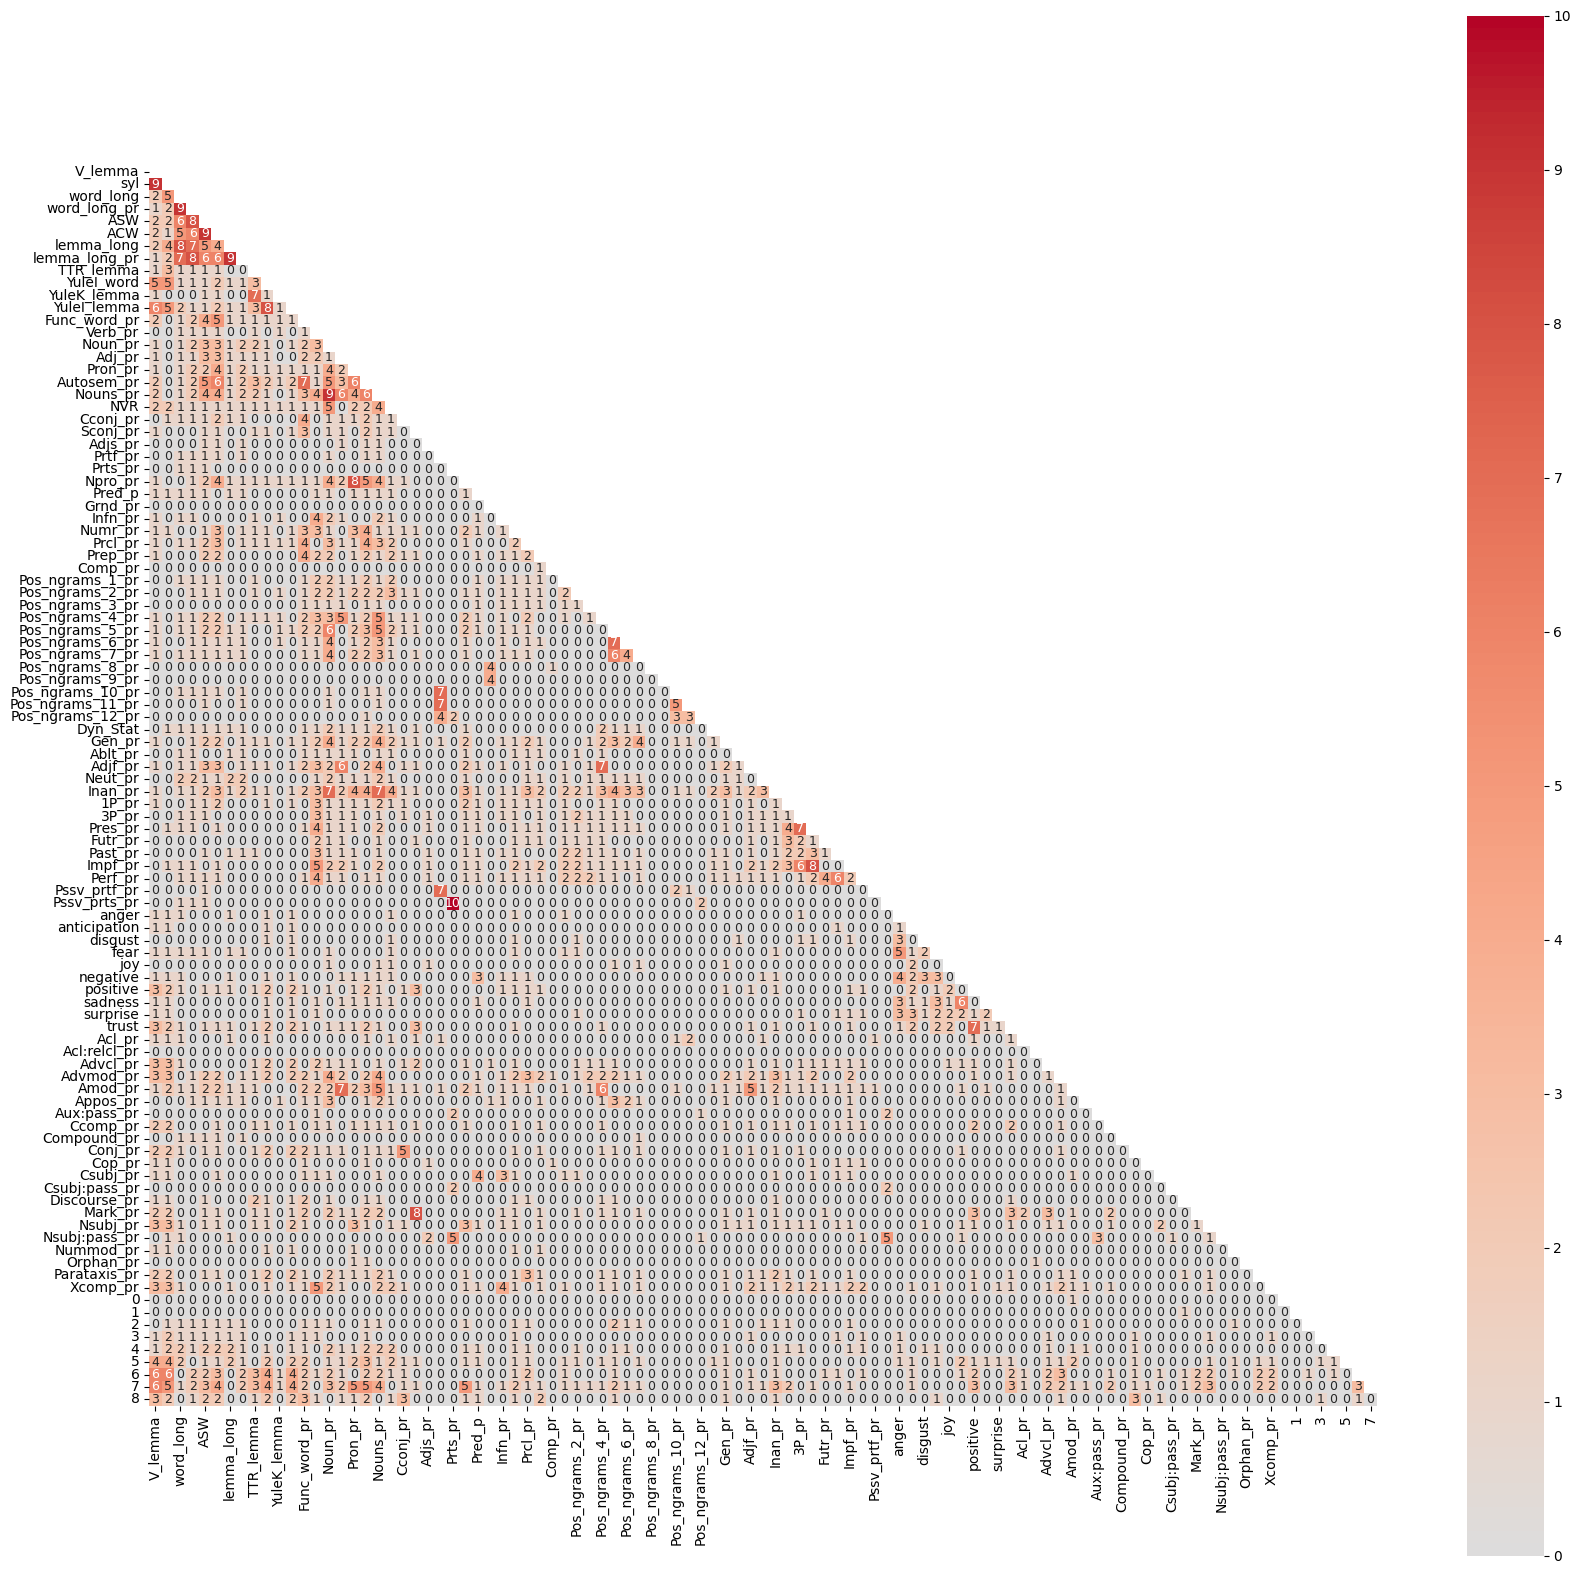

In [107]:
corr_whole = wholeDF[wholeDF.columns[3:]].corr(numeric_only=True)

drop_whole, mask_whole = cols2drop(corr_whole)

corr_whole = (corr_whole.abs() * 10).round()

plt.figure(figsize=(20, 20))
sns.heatmap(
    corr_whole,
    mask=mask_whole,
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.001,
    annot=True,
    annot_kws={"size": 9},
    cbar_kws={"ticks": [i for i in range(10 + 1)]},
)
plt.savefig(
    r"C:\Users\Ivan\Desktop\AI\0_Dissertation\CorrHeatmapWhole.png", bbox_inches="tight"
)

In [108]:
drop_whole

['Prts_pr']

In [109]:
wholeDF = wholeDF.drop(drop_whole, axis=1)

In [110]:
wholeDF[wholeDF.columns[3:]] = std_scaler.fit_transform(wholeDF[wholeDF.columns[3:]])
wholeDF.head().style.map(_df_colors)

,IDs,Primary Emotion,Emotion Class,V_lemma,syl,word_long,word_long_pr,ASW,ACW,lemma_long,lemma_long_pr,TTR_lemma,YuleI_word,YuleK_lemma,YuleI_lemma,Func_word_pr,Verb_pr,Noun_pr,Adj_pr,Pron_pr,Autosem_pr,Nouns_pr,NVR,Cconj_pr,Sconj_pr,Adjs_pr,Prtf_pr,Npro_pr,Pred_p,Grnd_pr,Infn_pr,Numr_pr,Prcl_pr,Prep_pr,Comp_pr,Pos_ngrams_1_pr,Pos_ngrams_2_pr,Pos_ngrams_3_pr,Pos_ngrams_4_pr,Pos_ngrams_5_pr,Pos_ngrams_6_pr,Pos_ngrams_7_pr,Pos_ngrams_8_pr,Pos_ngrams_9_pr,Pos_ngrams_10_pr,Pos_ngrams_11_pr,Pos_ngrams_12_pr,Dyn_Stat,Gen_pr,Ablt_pr,Adjf_pr,Neut_pr,Inan_pr,1P_pr,3P_pr,Pres_pr,Futr_pr,Past_pr,Impf_pr,Perf_pr,Pssv_prtf_pr,Pssv_prts_pr,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,Acl_pr,Acl:relcl_pr,Advcl_pr,Advmod_pr,Amod_pr,Appos_pr,Aux:pass_pr,Ccomp_pr,Compound_pr,Conj_pr,Cop_pr,Csubj_pr,Csubj:pass_pr,Discourse_pr,Mark_pr,Nsubj_pr,Nsubj:pass_pr,Nummod_pr,Orphan_pr,Parataxis_pr,Xcomp_pr,0,1,2,3,4,5,6,7,8
0,0107635181_00__00-channel-0-number-004_18310,С,1,-0.514089,-0.760113,-0.935962,-0.889061,-0.416990,-0.207404,-0.730275,-0.693660,0.737110,-0.450488,-0.395591,-0.519674,-0.526931,1.046548,1.052569,-0.504816,-0.184464,0.597924,0.627962,0.290936,-0.567475,-0.383154,-0.158000,-0.090520,-1.105283,-0.336580,-0.049948,-0.475165,-0.312745,-0.882008,0.842261,-0.131105,-0.323024,2.504106,-0.325820,1.970682,-0.302208,-0.124194,-0.216431,-0.023919,-0.016935,-0.056890,-0.049991,-0.032819,-0.350976,-0.595587,-0.227658,0.982744,-0.319830,1.547532,-0.457701,3.602193,2.814668,-0.281872,-0.596896,2.408979,-0.601743,-0.077563,-0.114610,-0.247878,-0.275893,-0.229496,-0.341865,-0.150192,-0.524090,-0.655286,-0.330572,-0.204182,-0.556583,-0.134525,-0.058756,2.543413,-1.430485,-0.450748,-0.176175,-0.058756,-0.206007,-0.016935,-0.436399,-0.194387,-0.262593,-0.033884,-0.270001,-0.410022,-1.671954,-0.134525,-0.115604,-0.050862,-0.426112,-0.574260,-0.023953,-0.123694,-0.270043,-0.547146,1.884989,-0.481358,-0.325585,-1.310627,1.079121
1,0107635181_00__00-channel-0-number-005_22100,С,1,0.913288,0.922847,1.162133,0.614111,0.392989,0.145892,0.599161,0.250862,-0.146634,-0.450488,-0.395591,-0.519674,-1.036698,0.588585,-0.585209,-0.504816,1.220899,-0.491954,-0.725691,-0.464899,0.711299,-0.383154,-0.158000,-0.090520,0.405989,-0.336580,-0.049948,-0.475165,-0.312745,-0.882008,-0.856963,-0.131105,-0.323024,-0.434527,1.707207,0.860096,-0.302208,-0.124194,-0.216431,-0.023919,-0.016935,-0.056890,-0.049991,-0.032819,-0.350976,-0.595587,-0.227658,0.233632,-0.319830,-0.324001,1.029751,1.729988,1.206735,1.516056,-0.596896,0.909176,0.411637,-0.077563,-0.114610,3.511241,3.198171,-0.229496,2.504020,-0.150192,1.278696,0.837619,-0.330572,-0.204182,1.184548,-0.134525,-0.058756,-0.393172,0.699063,-0.450748,-0.176175,-0.058756,-0.206007,-0.016935,-0.436399,-0.194387,-0.262593,-0.033884,-0.270001,-0.410022,0.598103,-0.134525,-0.115604,-0.050862,-0.426112,1.741370,-0.023953,-0.123694,-0.270043,-0.547146,-0.758163,0.309493,0.222504,0.421864,1.079121
2,0107635181_00__00-channel-0-number-006_26690,С,1,1.270132,0.157865,-0.935962,-0.889061,-1.337421,-1.017041,-0.730275,-0.693660,-0.072988,2.393151,-0.141886,2.354583,1.155302,-0.842550,-0.073404,1.436471,-0.779040,-0.258409,0.627962,1.424689,-0.567475,-0.383154,-0.158000,4.947925,-0.412617,-0.336580,-0.049948,-0.475165,-0.312745,-0.208030,1.691873,4.611830,-0.323024,-0.434527,-0.325820,0.749038,-0.302208,-0.124194,-0.216431,-0.023919,-0.016935,-0.056890,-0.049991,-0.032819,-0.499638,-0.595587,-0.227658,0.158721,-0.319830,0.260853,-0.457701,-0.516658,-0.722784,-0.281872,-0.596896,-0.890587,-0.601743,7.489911,-0.114610,-0.247878,-0.275893,4.120944,2.504020,-0.150192,3.081481,-0.655286,-0.330572,-0.204182,-0.556583,-0.134525,-0.058756,-0.393172,0.699063,2.218536,-0.176175,-0.058756,-0.206007,-0.016935,-0.436399,-0.194387,-0.262593,-0.033884,-0.270001,-0.410022,0.598103,-0.134525,-0.115604,-0.050862,2.346798,-0.574260,-0.023953,-0.123694,-0.270043,-0.547146,-0.758163,1.891196,0.222504,-0.155633,4.307229
3,010763696

•	Эмоции:
```python
o	Г: грусть, печаль, горе, разочарование, огорчение
o	З: злость, гнев, досада
o	Р: радость, восторг, веселье, смех
o	У: удивление, изумление, непонимание, растерянность, недоумение, сомнение
o	В: волнение, возбуждение, беспокойство, тревога
o	Ж: раздражение, нетерпеливость
o	Н: недовольство, возмущение
o	О: обида, расстройство
o	Б: обречённость, усталость, безысходность, слабость
o	С: страх, испуг, паника, отчаяние
```

```py
{'С': 36,
 'О': 50,
 'Н': 848,
 'Ж': 292,
 'У': 211,
 'Р': 13,
 'Г': 70,
 'Б': 117,
 'З': 177,
 'В': 1758}
```
Г + Б + О

В + С

Р + У

З + Н + Ж

In [111]:
classes_merge_table = {1: 10,
                       2: 7,
                       3: 3,
                       4: 3,
                       5: 5,
                       6: 5,
                       7: 7,
                       8: 7,
                       9: 3,
                       10: 10}

In [112]:
wholeDF = wholeDF.replace({"Emotion Class": classes_merge_table})
set(wholeDF["Emotion Class"])

{3, 5, 7, 10}

In [113]:
X_train, X_test, y_train, y_test = train_test_split(wholeDF[wholeDF.columns[3:]], 
                                                    wholeDF["Emotion Class"], 
                                                    test_size=0.1, # данных не так много, берём максимум на обучение 
                                                    shuffle=True, 
                                                    random_state=42)

## Decision Tree

In [114]:
from time import time

In [115]:
start = time()

dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X=X_train, y=y_train)

print(f"Fit duration: {time() - start:.3}s \n")

print("Test:")
print_metrics(dtc.predict(X_test), y_test, dtc.predict_proba(X_test))

print("\nTrain:")
print_metrics(dtc.predict(X_train), y_train, dtc.predict_proba(X_train))

Fit duration: 0.264s 

Test:
MSE: 18.441260744985673
Accuracy: 0.4699140401146132
F-score: 0.4686085346185981
ROC-AUC: 0.5460255303718614

Train:
MSE: 0.0
Accuracy: 1.0
F-score: 1.0
ROC-AUC: 1.0


In [116]:
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, 50, 100, None]:
    dt = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_test)
    auc = roc_auc_score(y_test, y_pred, multi_class='ovr')
    print(f'{str(depth):>4} -> {auc:.3}')

   1 -> 0.501
   2 -> 0.537
   3 -> 0.513
   4 -> 0.509
   5 -> 0.488
   6 -> 0.495
  10 -> 0.51


  15 -> 0.523
  20 -> 0.517
  50 -> 0.546
 100 -> 0.546
None -> 0.546


Проведём гридсёрч для подбора лучших параметров модели

In [117]:
# parameters = {
#     "criterion": ['gini', 'entropy', 'log_loss'],
#     "max_depth": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
#     "splitter": ['best', 'random'],
#     # "min_samples_split": [2, 2.5, 3],
#     # "min_samples_leaf": [1, 2, 2.5, 3], 
#     # "min_weight_fraction_leaf": [0.0, 0.1, 1.0, 1.5, 2],
#     "max_features": ["sqrt", "log2", None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1],
#     # "max_leaf_nodes": [None, 1, 2, 5],
#     "min_impurity_decrease": [0, 1, 2, 3],
#     "class_weight": [None, "balanced"],
#     # "ccp_alpha": [0, 1, 0.2, 2.5]
# }

In [118]:
# dec_tree = DecisionTreeClassifier(random_state=42)

Закомментил ячейки с гридсёрчем так как они долго выполняются, а результат я уже применил

In [119]:
# dt_grid = GridSearchCV(estimator=dec_tree, 
#                        param_grid=parameters,
#                        scoring=None,
#                        refit=True,
#                        verbose=4,
#                        pre_dispatch="2*n_jobs",
#                     #    error_score=...,
#                        return_train_score=False,
#                        cv=5,
#                        n_jobs=-1)
# dt_grid.fit(X_train, y_train)

In [120]:
# dt_grid.best_params_

In [121]:
dec_tree = DecisionTreeClassifier(criterion="entropy", 
                                  splitter="best", 
                                  max_depth = 5, # я не понимаю, почему не 3, если гридсёрч выдаёт его, но лучше результат с 5
                                  min_samples_split = 2, 
                                  min_samples_leaf = 1, 
                                  min_weight_fraction_leaf = 0, 
                                  max_features = 0.4, 
                                  random_state = 42, 
                                  max_leaf_nodes = None, 
                                  min_impurity_decrease = 0, 
                                  class_weight = None, 
                                  ccp_alpha = 0
)

In [122]:
dec_tree.fit(X=X_train, y=y_train)
print("Test:")
print_metrics(dec_tree.predict(X_test), y_test, dec_tree.predict_proba(X_test))
print("\nTrain:")
print_metrics(dec_tree.predict(X_train), y_train, dec_tree.predict_proba(X_train))

Test:
MSE: 20.363896848137536
Accuracy: 0.501432664756447
F-score: 0.4334072489373074
ROC-AUC: 0.5658533687890733

Train:
MSE: 17.871615164064988
Accuracy: 0.5508123606244026
F-score: 0.4793252967469574
ROC-AUC: 0.6621615724628082


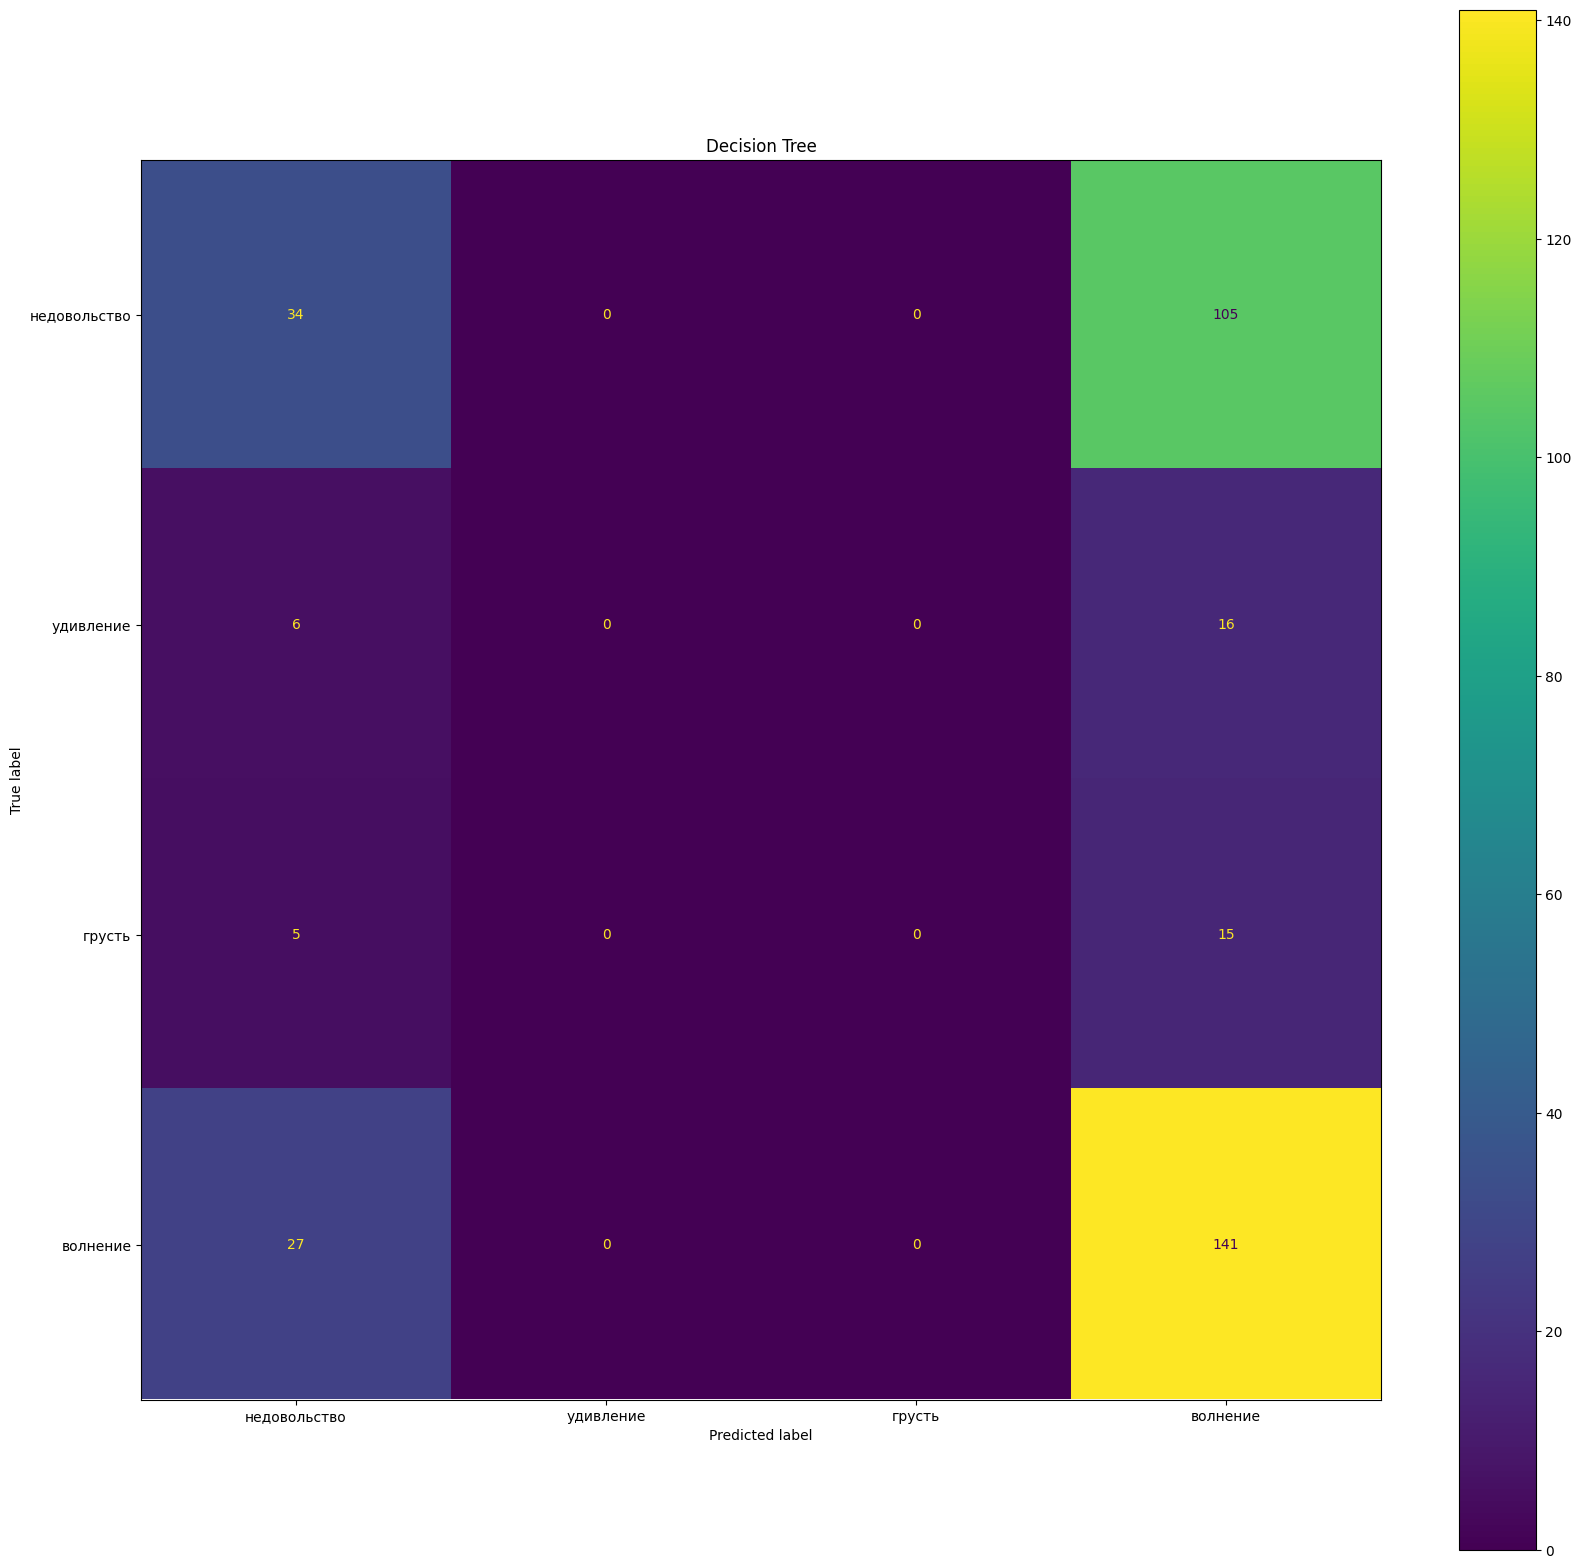

In [123]:
show_conf_matrx(y_test, dec_tree.predict(X_test), dec_tree.classes_, "Decision Tree")

In [124]:
dec_tree.classes_

array([ 3,  5,  7, 10], dtype=int64)

In [125]:
emo2num = {'С': 1,
           'О': 2,
           'Н': 3,
           'Ж': 4,
           'У': 5,
           'Р': 6,
           'Г': 7,
           'Б': 8,
           'З': 9,
           'В': 10}

num2emo = {val: key for key, val in emo2num.items()}

letter2emo = {
"Г": "грусть",
"З": "злость",
"Р": "радость",
"У": "удивление",
"В": "волнение",
"Ж": "раздражение",
"Н": "недовольство",
"О": "обида",
"Б": "обречённость",
"С": "страх"
}

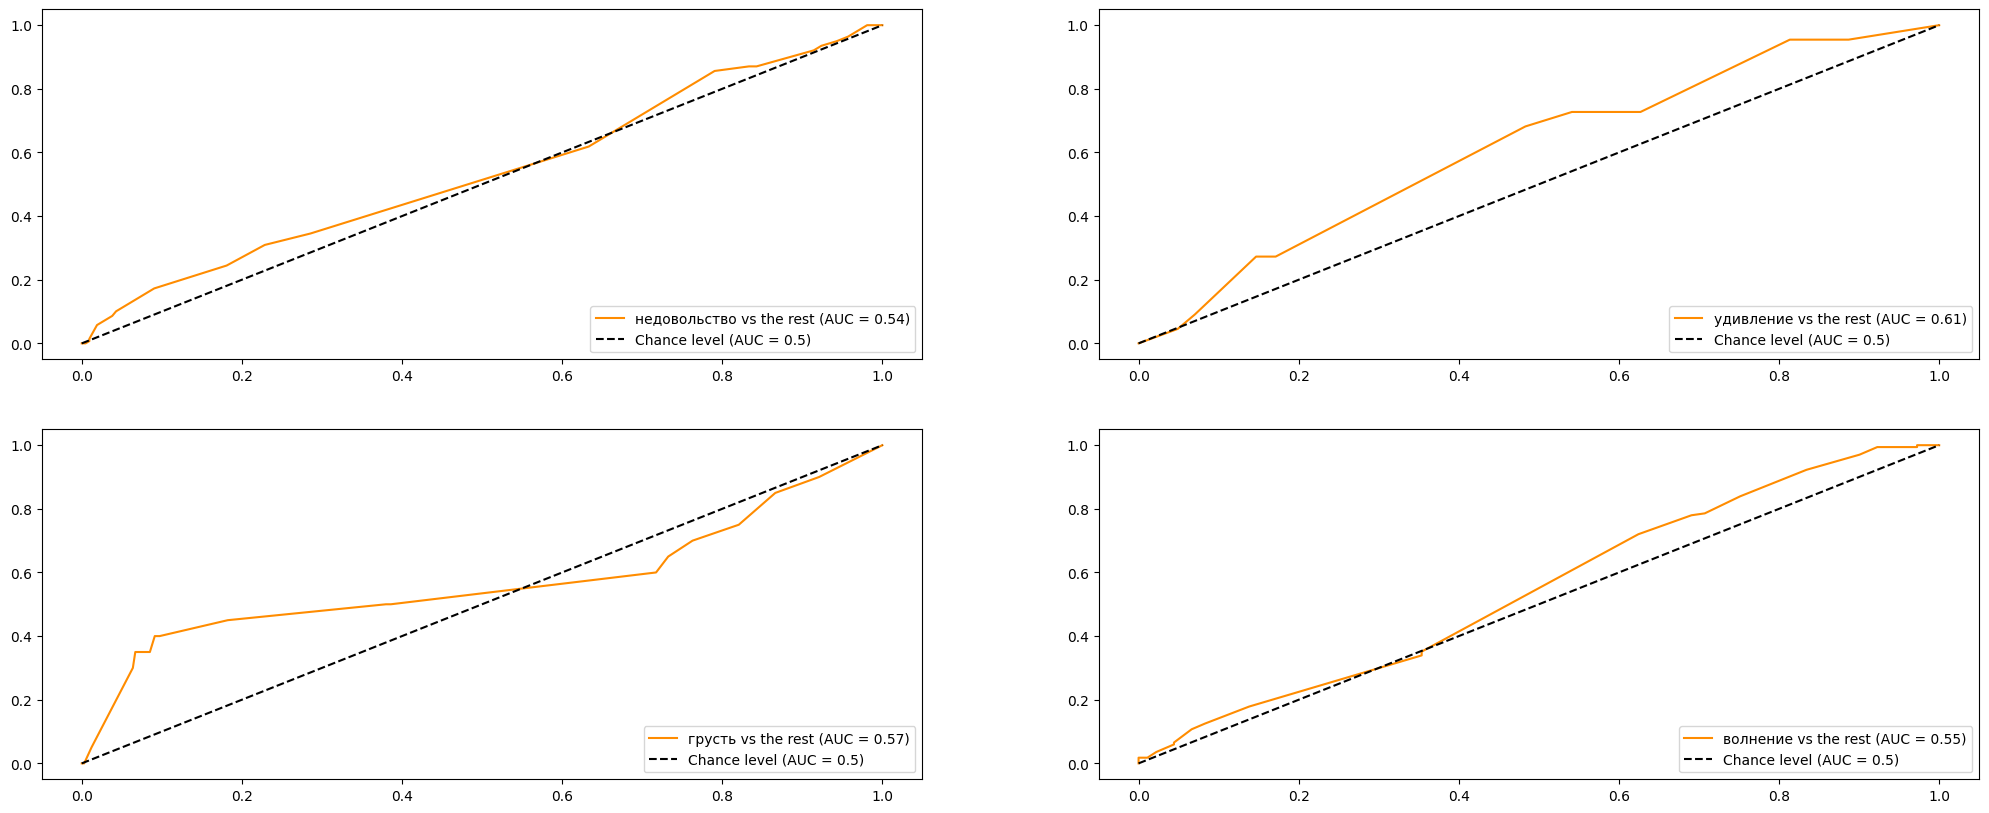

In [126]:
show_roc_curves(y_train, y_test, dec_tree.predict_proba(X_test), classes=dec_tree.classes_)

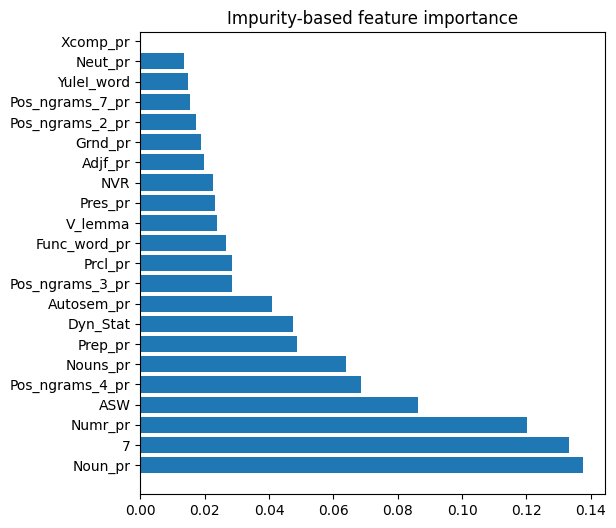

In [127]:
show_feature_importances(dec_tree.feature_importances_, X_test.columns, "Impurity-based feature importance")

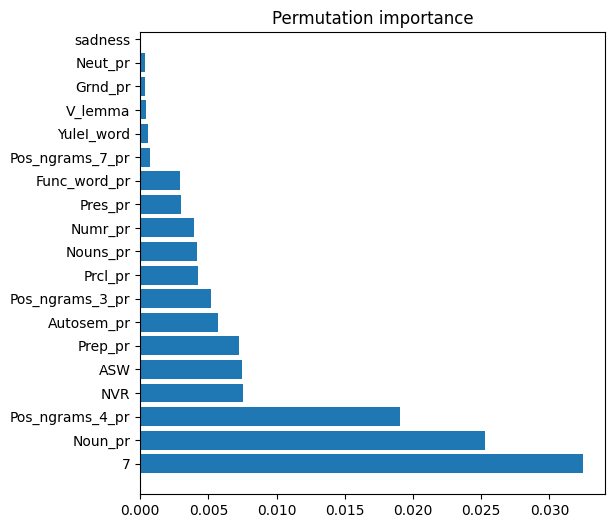

In [128]:
perm_imp_dec_tree = permutation_importance(dec_tree, X_train, y_train, n_repeats=30, n_jobs=-1, random_state=42)
show_feature_importances(perm_imp_dec_tree.importances_mean, X_test.columns, "Permutation importance")

## Random Forest

In [129]:
start = time()
rfc = RandomForestClassifier(n_estimators=1000,
                             criterion="gini",
                             max_depth=None, 
                             min_samples_split=2,
                             min_samples_leaf=1,
                             min_weight_fraction_leaf=0,
                             max_features="sqrt",
                             max_leaf_nodes=None,
                             min_impurity_decrease=0,
                             bootstrap=True,
                             oob_score=False,
                             n_jobs=-1,
                             random_state=42,
                             verbose=0,
                             warm_start=False,
                             class_weight=None,
                             ccp_alpha=0,
                             max_samples=None
)
rfc.fit(X=X_train, y=y_train)
print(f"Fit duration: {time() - start:.3}s \n")

print("Test:")
print_metrics(rfc.predict(X_test), y_test, rfc.predict_proba(X_test))
print("\nTrain:")
print_metrics(rfc.predict(X_train), y_train, rfc.predict_proba(X_train))

Fit duration: 6.35s 

Test:
MSE: 22.297994269340975
Accuracy: 0.4699140401146132
F-score: 0.4252095984562739
ROC-AUC: 0.6156888122779945

Train:
MSE: 0.0
Accuracy: 1.0
F-score: 1.0
ROC-AUC: 1.0


In [130]:
# parameters = {
#     "n_estimators": [1000, 1500, 700],
#     "max_depth": [20, 25, 15],
# }

# rfc = RandomForestClassifier(n_jobs=-1,
#                              random_state=42,
#                              max_features="log2",
#                              criterion="gini")

# rfc_grid = GridSearchCV(estimator=rfc, 
#                        param_grid=parameters,
#                        scoring=None,
#                        refit=True,
#                        verbose=4,
#                        pre_dispatch="2*n_jobs",
#                     #    error_score=...,
#                        return_train_score=False,
#                        cv=5,
#                        n_jobs=-1)
# rfc_grid.fit(X_train, y_train)

# rfc_grid.best_params_

In [131]:
rfc = RandomForestClassifier(max_depth=20, 
                             n_estimators=1000,
                             n_jobs=-1,
                             random_state=42,
                             max_features="log2",
                             criterion="gini")

rfc.fit(X=X_train, y=y_train)

print("Test:")
print_metrics(rfc.predict(X_test), y_test, rfc.predict_proba(X_test))
print("\nTrain:")
print_metrics(rfc.predict(X_train), y_train, rfc.predict_proba(X_train))

Test:
MSE: 22.197707736389685
Accuracy: 0.4699140401146132
F-score: 0.41993840748486305
ROC-AUC: 0.6074647359491272

Train:
MSE: 0.008601465434851864
Accuracy: 0.9990442816183498
F-score: 0.9990411592729932
ROC-AUC: 1.0


In [132]:
# fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(30, 10))
# plt.subplots_adjust(hspace=0.5)
# fig.suptitle("Confusion matrices", fontsize=18, y=0.95)
# mcm_rfc = multilabel_confusion_matrix(y_test, rfc.predict(X_test), labels=rfc.classes_)

# for confusion_matrix, ax, klas in zip(mcm_rfc, axs.ravel(), rfc.classes_):
#     disp = ConfusionMatrixDisplay(confusion_matrix, display_labels=[letter2emo[num2emo[klas]], "other"])
#     disp.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation="vertical")

# plt.show()

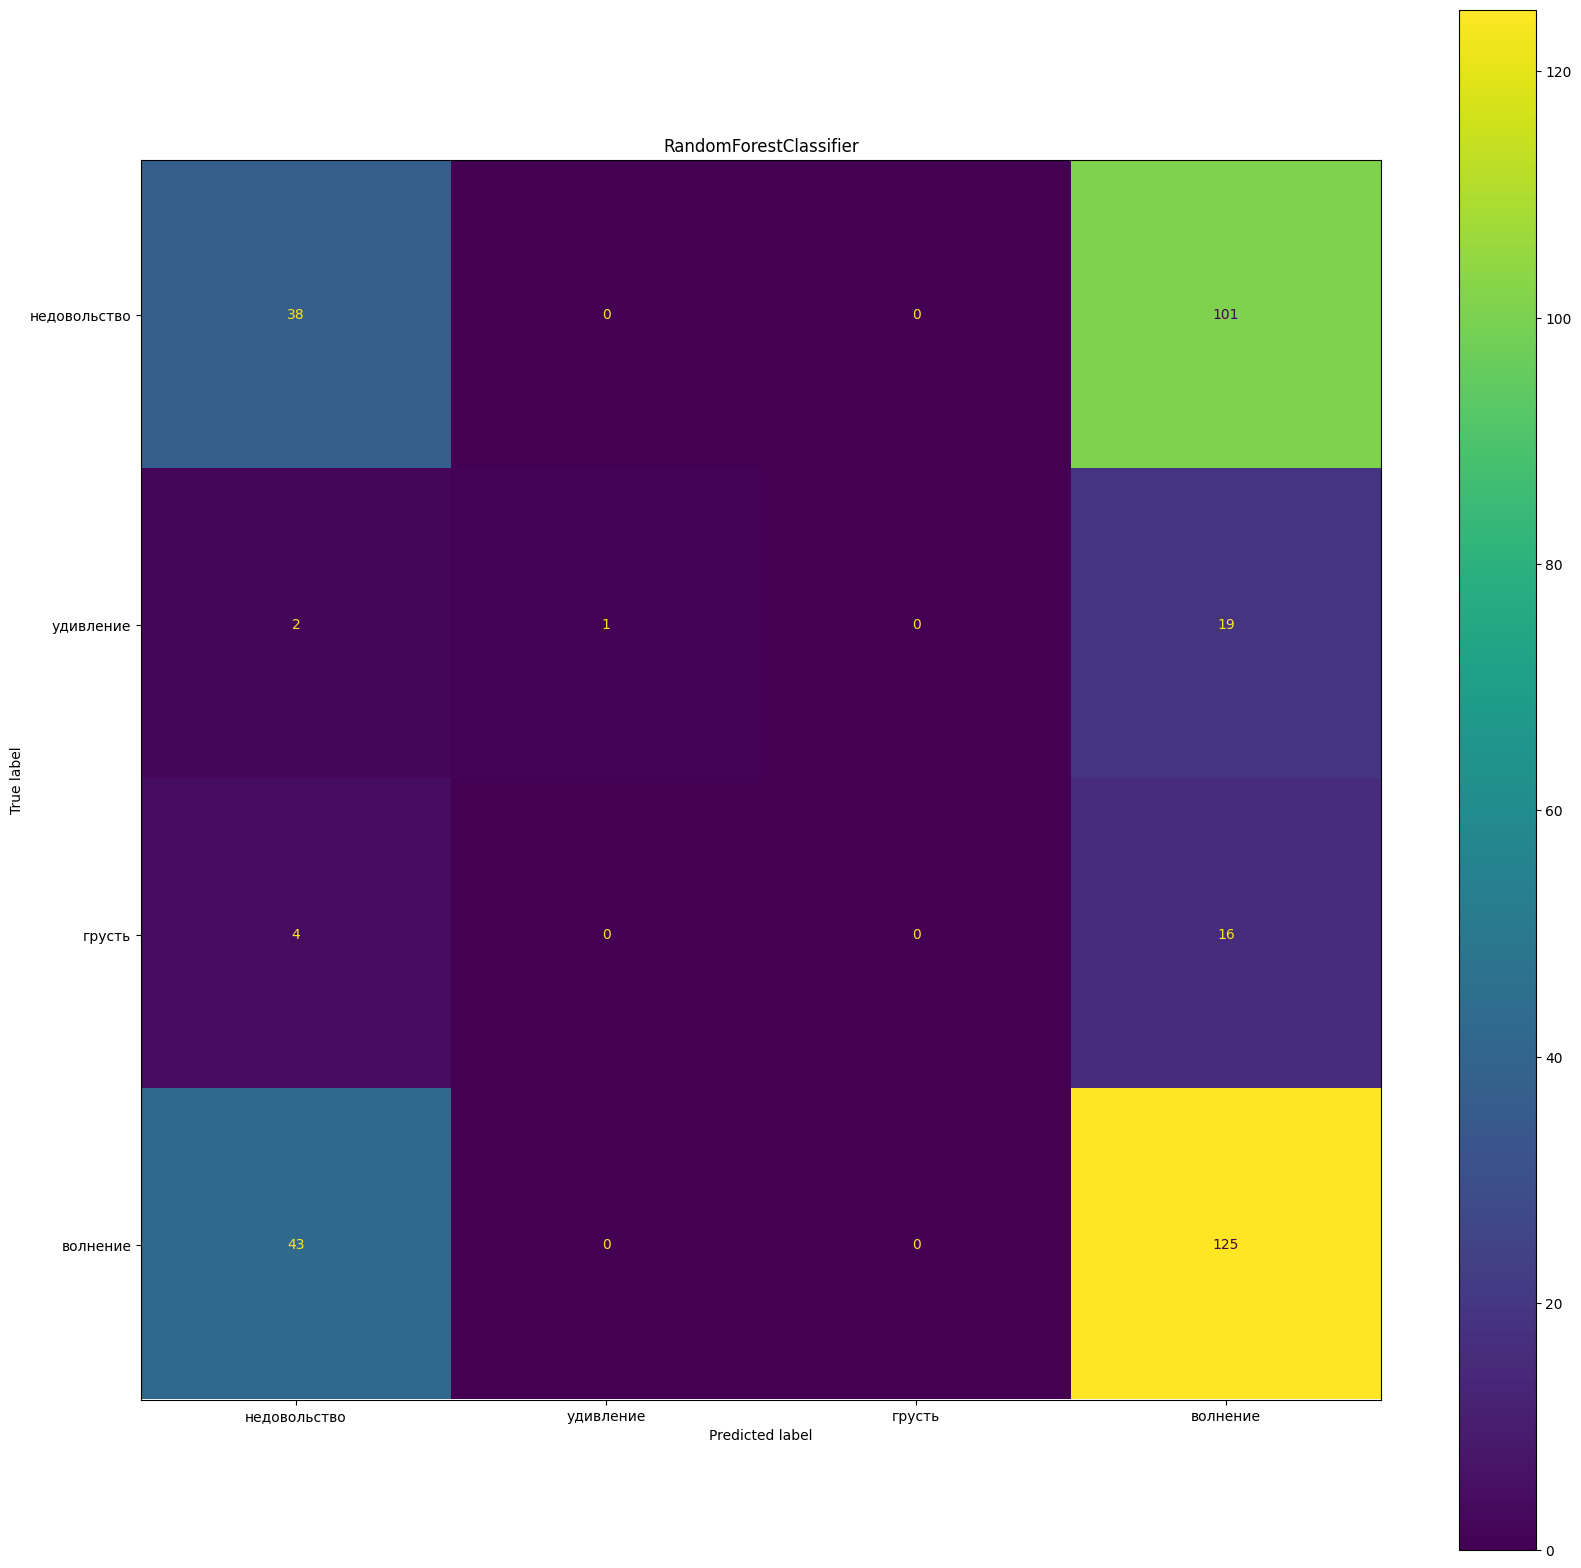

In [133]:
show_conf_matrx(y_test, rfc.predict(X_test), rfc.classes_, "RandomForestClassifier")

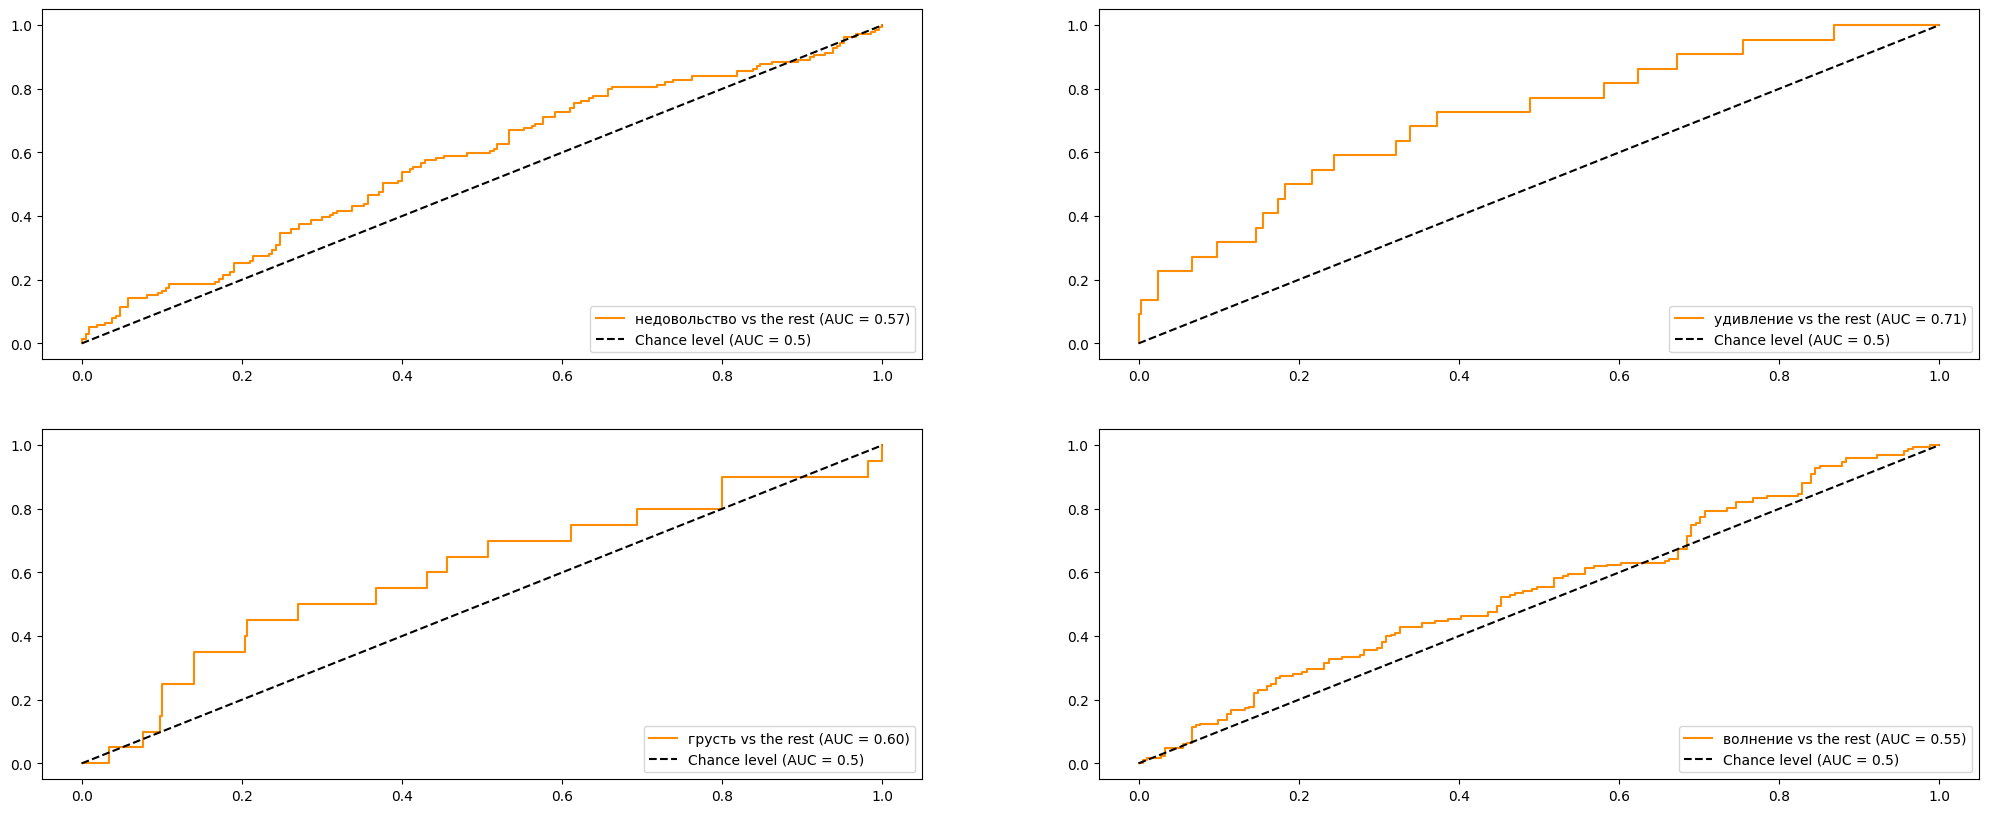

In [134]:
show_roc_curves(y_train, y_test, y_score=rfc.predict_proba(X_test), classes=rfc.classes_)

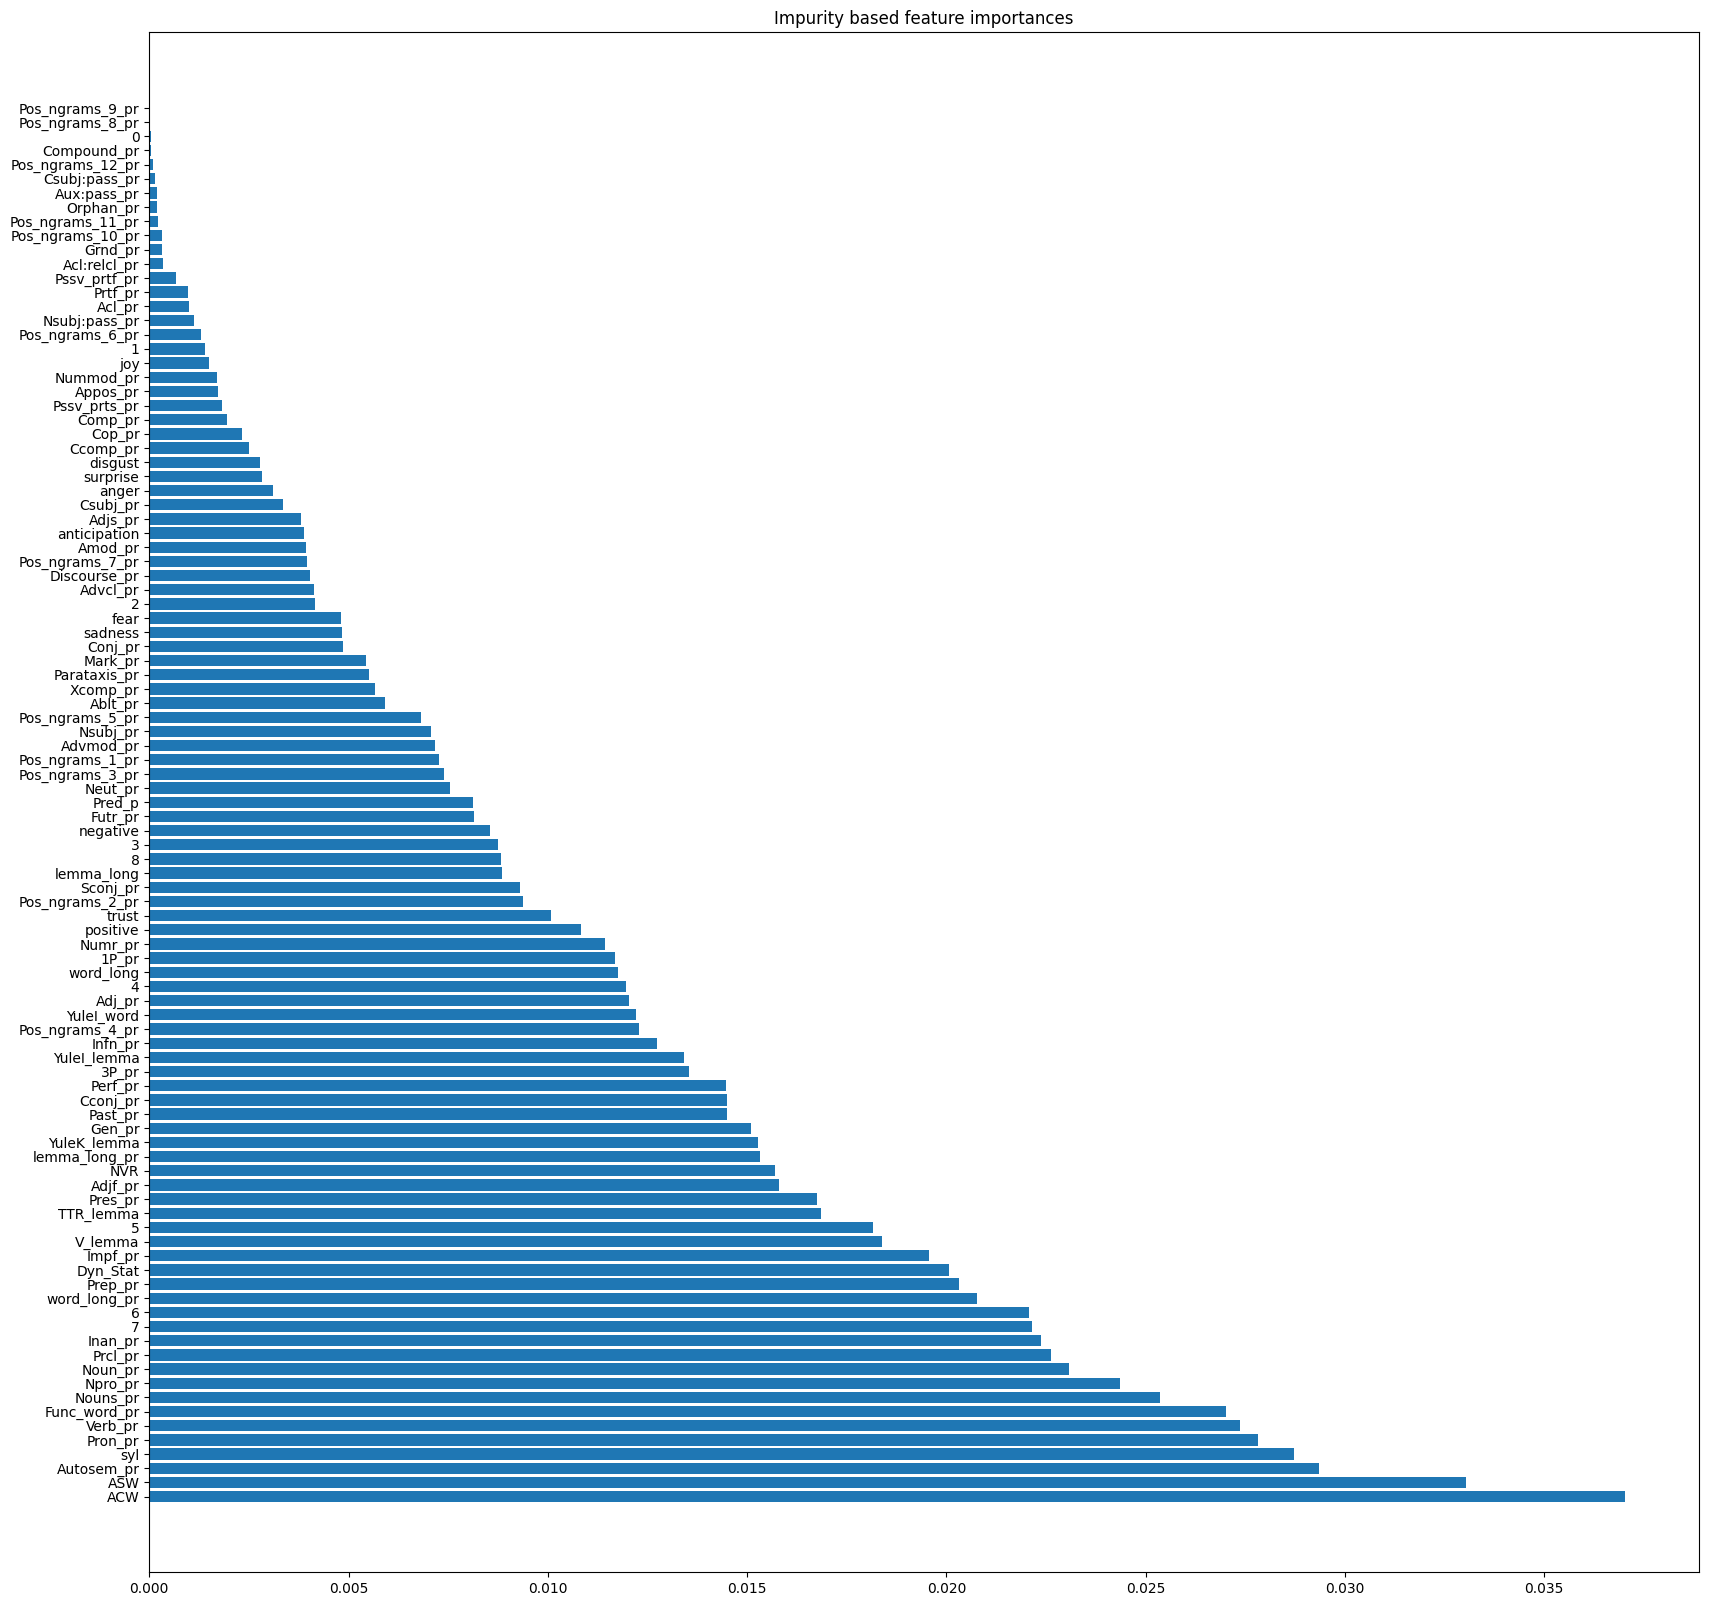

In [135]:
show_feature_importances(rfc.feature_importances_, X_test.columns, "Impurity based feature importances", size=(20,20))

In [136]:
perm_imp_rfc = permutation_importance(rfc, X_train, y_train, n_repeats=5, n_jobs=-1, random_state=42)

KeyboardInterrupt: 

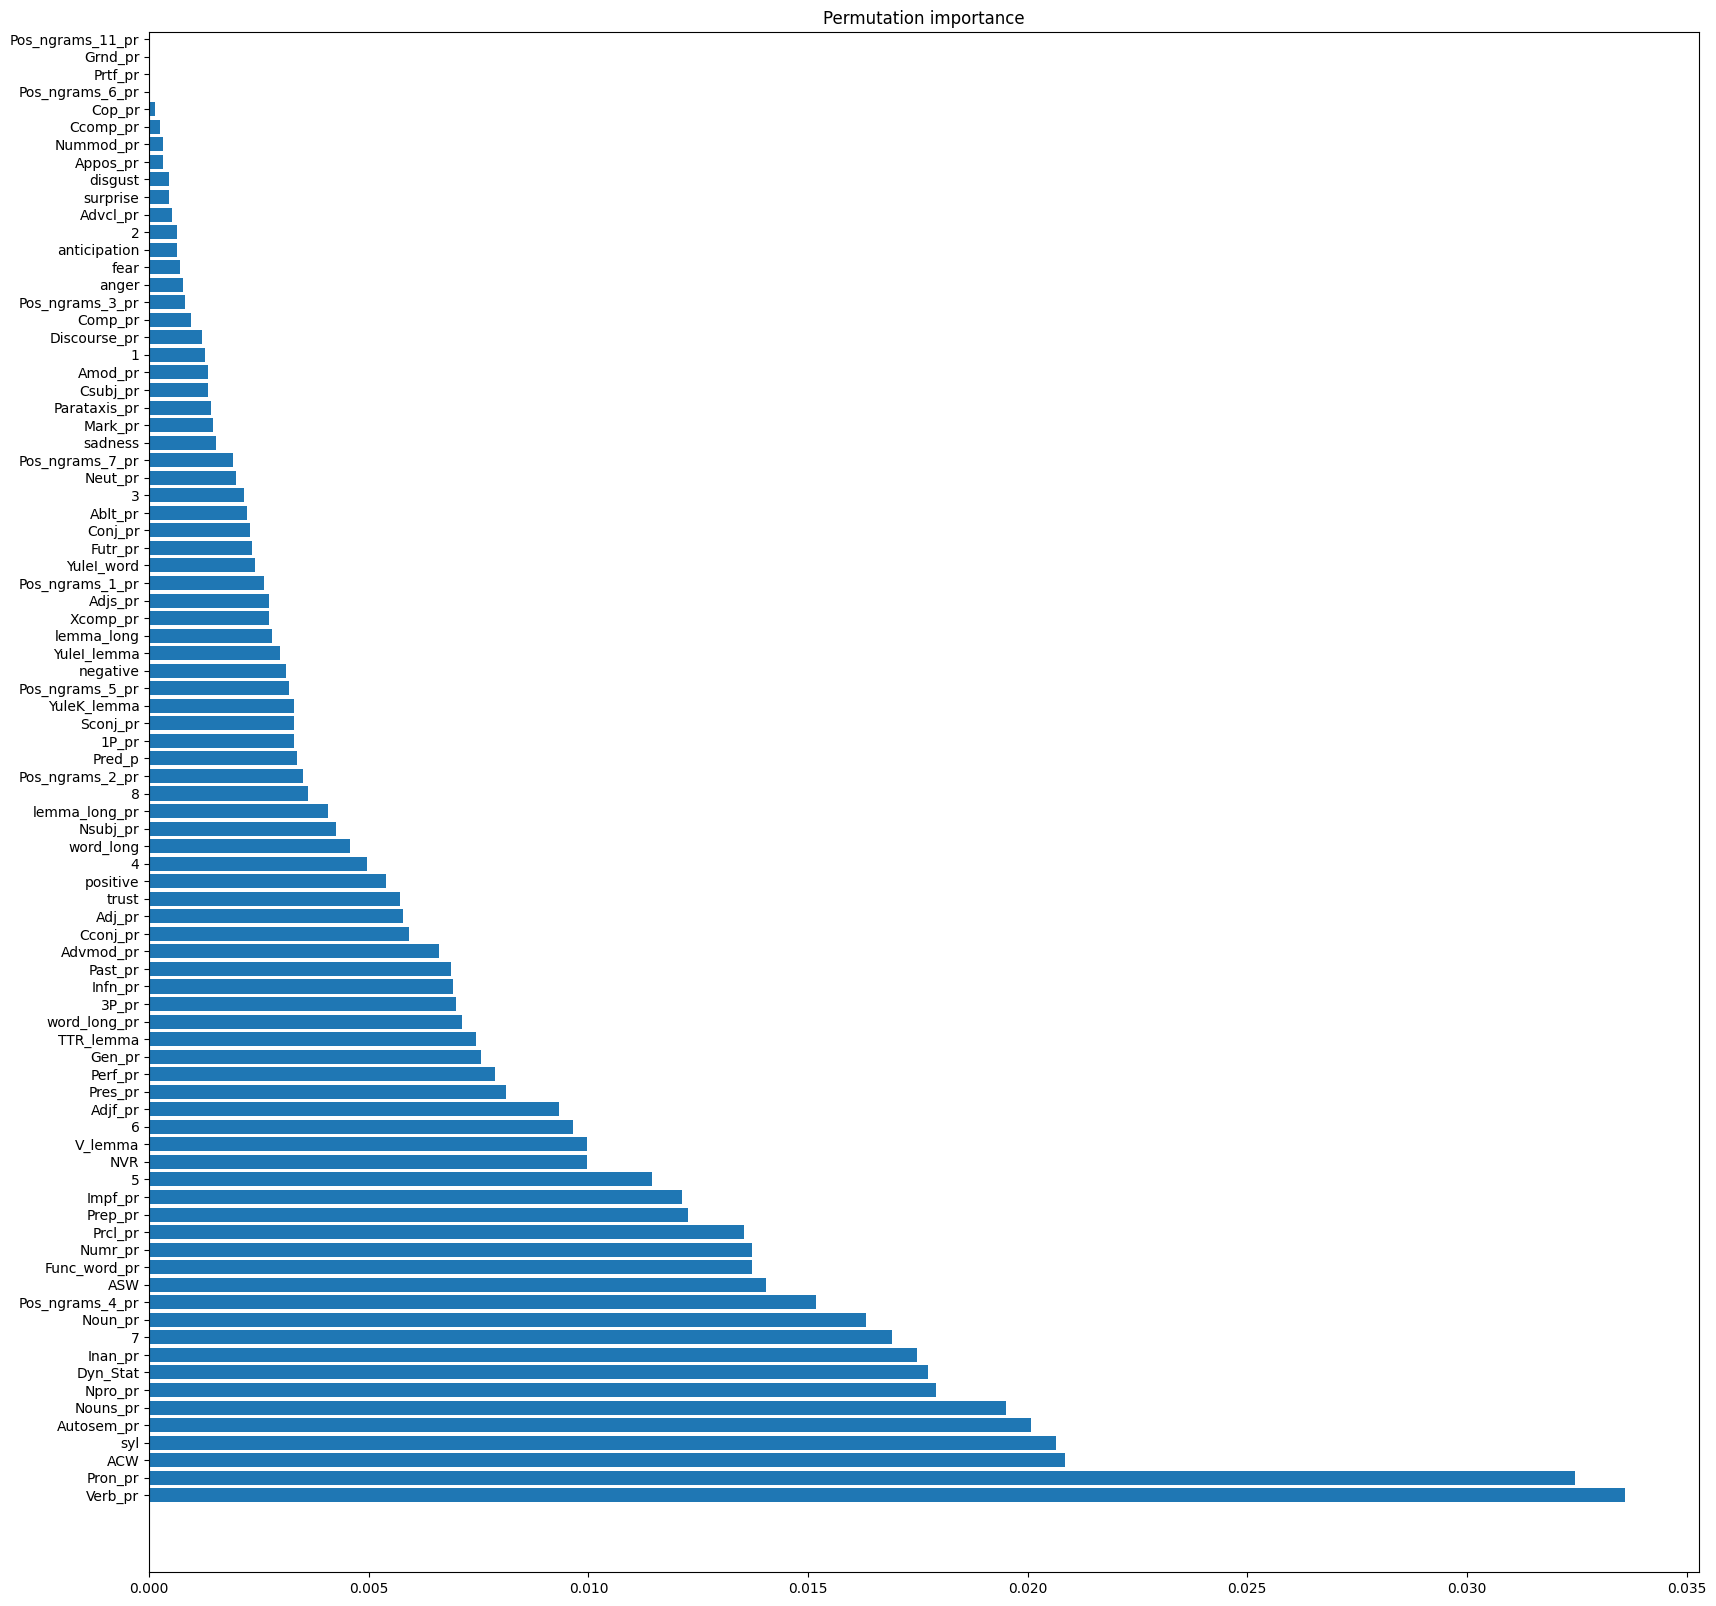

In [ ]:
show_feature_importances(perm_imp_rfc.importances_mean, X_test.columns, "Permutation importance", size=(20,20))

## CatBoost

In [137]:
cbc = CatBoostClassifier()

cbc.fit(X_train, y_train)
preds_class = cbc.predict(X_test)
print_metrics(preds_class, y_test, cbc.predict_proba(X_test))

Learning rate set to 0.08388
0:	learn: 1.3377426	total: 38.2ms	remaining: 38.1s
1:	learn: 1.2970710	total: 53.8ms	remaining: 26.8s
2:	learn: 1.2618426	total: 69.4ms	remaining: 23.1s
3:	learn: 1.2314932	total: 170ms	remaining: 42.2s
4:	learn: 1.2048159	total: 226ms	remaining: 45.1s
5:	learn: 1.1821538	total: 282ms	remaining: 46.7s
6:	learn: 1.1617347	total: 334ms	remaining: 47.4s
7:	learn: 1.1451048	total: 378ms	remaining: 46.8s
8:	learn: 1.1297987	total: 394ms	remaining: 43.4s
9:	learn: 1.1156955	total: 428ms	remaining: 42.4s
10:	learn: 1.1033668	total: 451ms	remaining: 40.5s
11:	learn: 1.0922407	total: 461ms	remaining: 38s
12:	learn: 1.0817165	total: 472ms	remaining: 35.9s
13:	learn: 1.0714021	total: 485ms	remaining: 34.1s
14:	learn: 1.0638024	total: 496ms	remaining: 32.6s
15:	learn: 1.0557135	total: 509ms	remaining: 31.3s
16:	learn: 1.0497690	total: 521ms	remaining: 30.1s
17:	learn: 1.0431445	total: 541ms	remaining: 29.5s
18:	learn: 1.0376379	total: 556ms	remaining: 28.7s
19:	learn: 

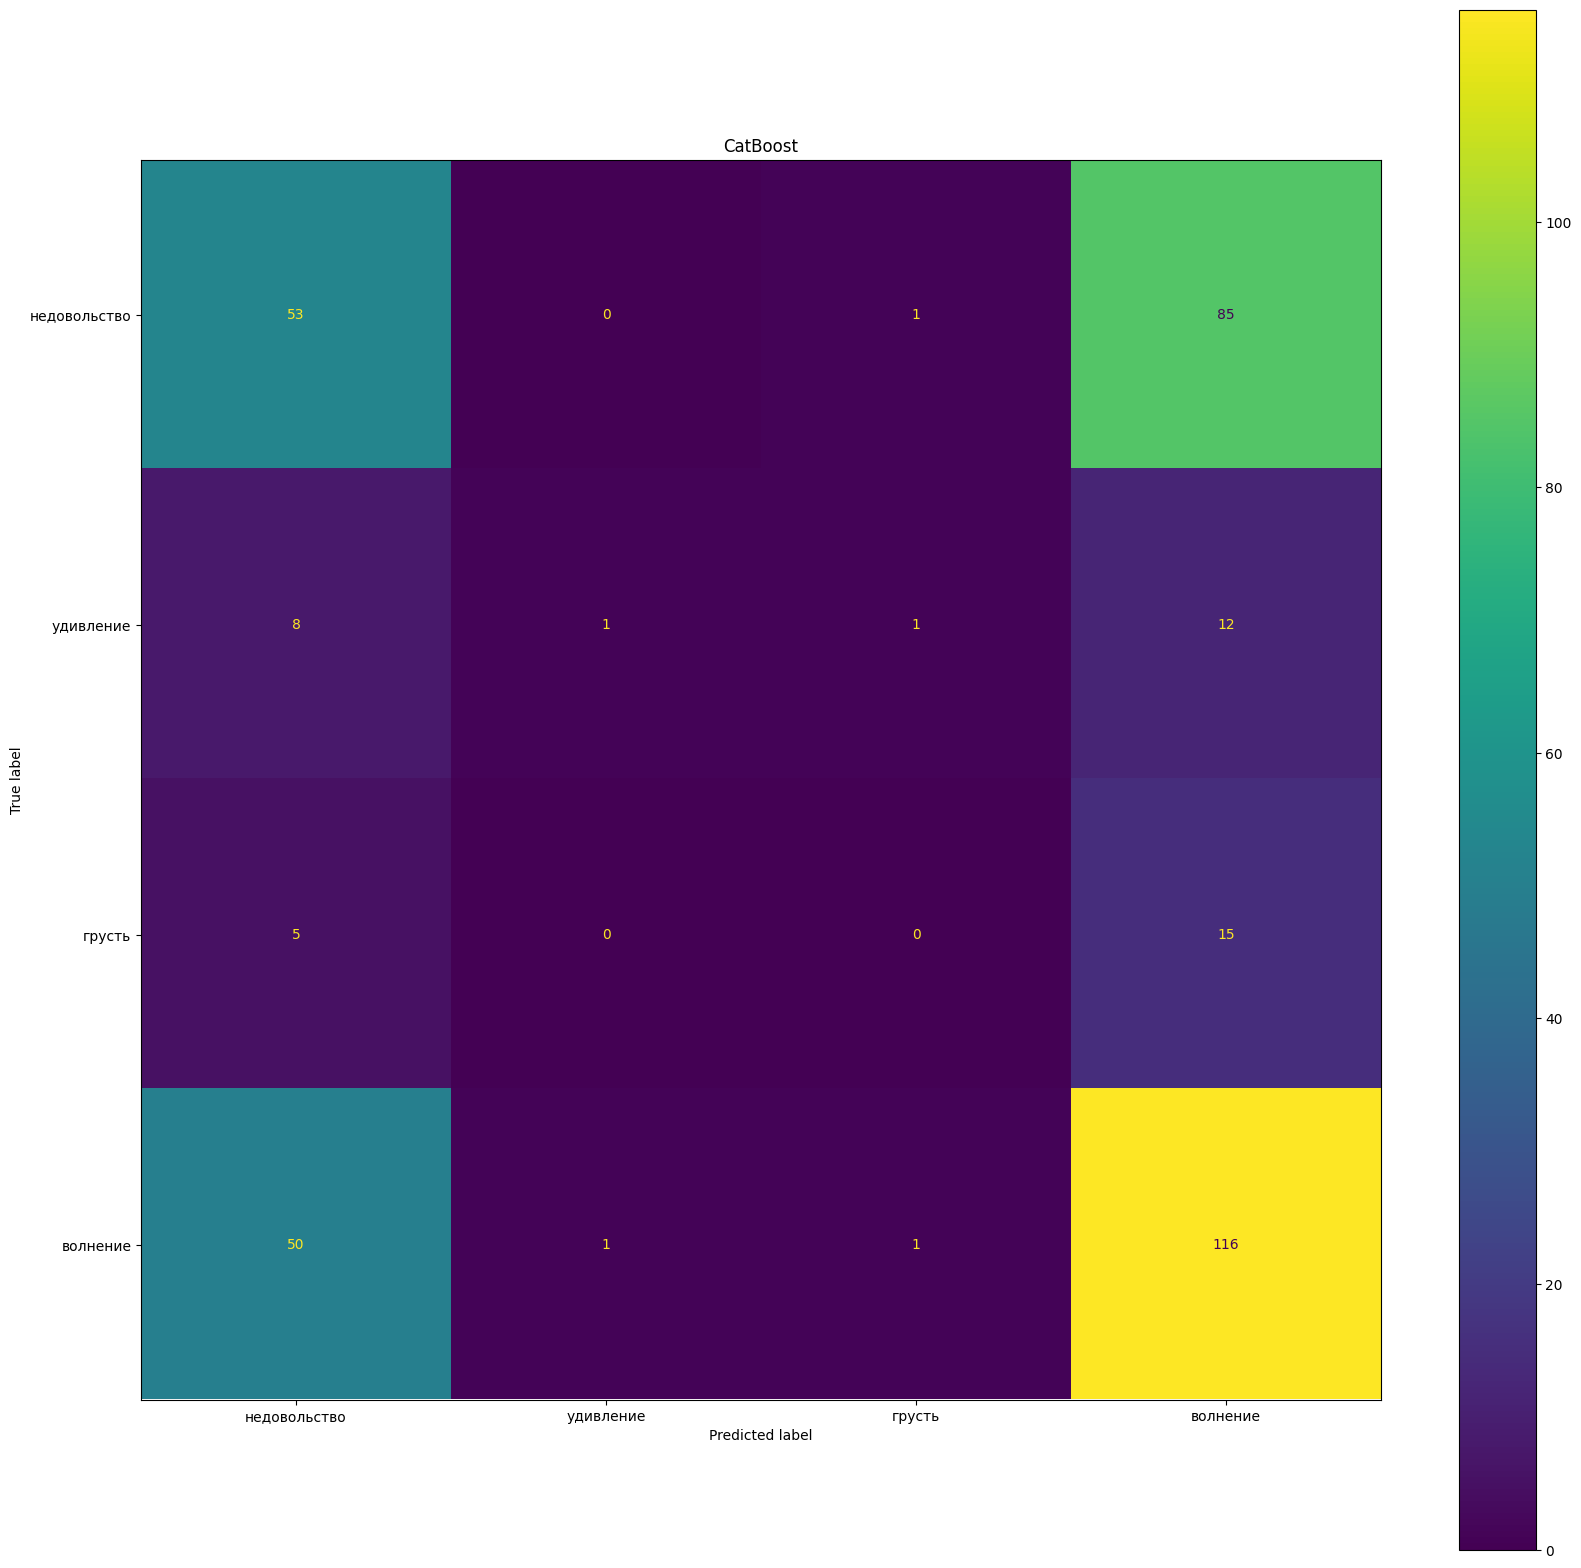

In [138]:
show_conf_matrx(y_test, cbc.predict(X_test), cbc.classes_, "CatBoost")

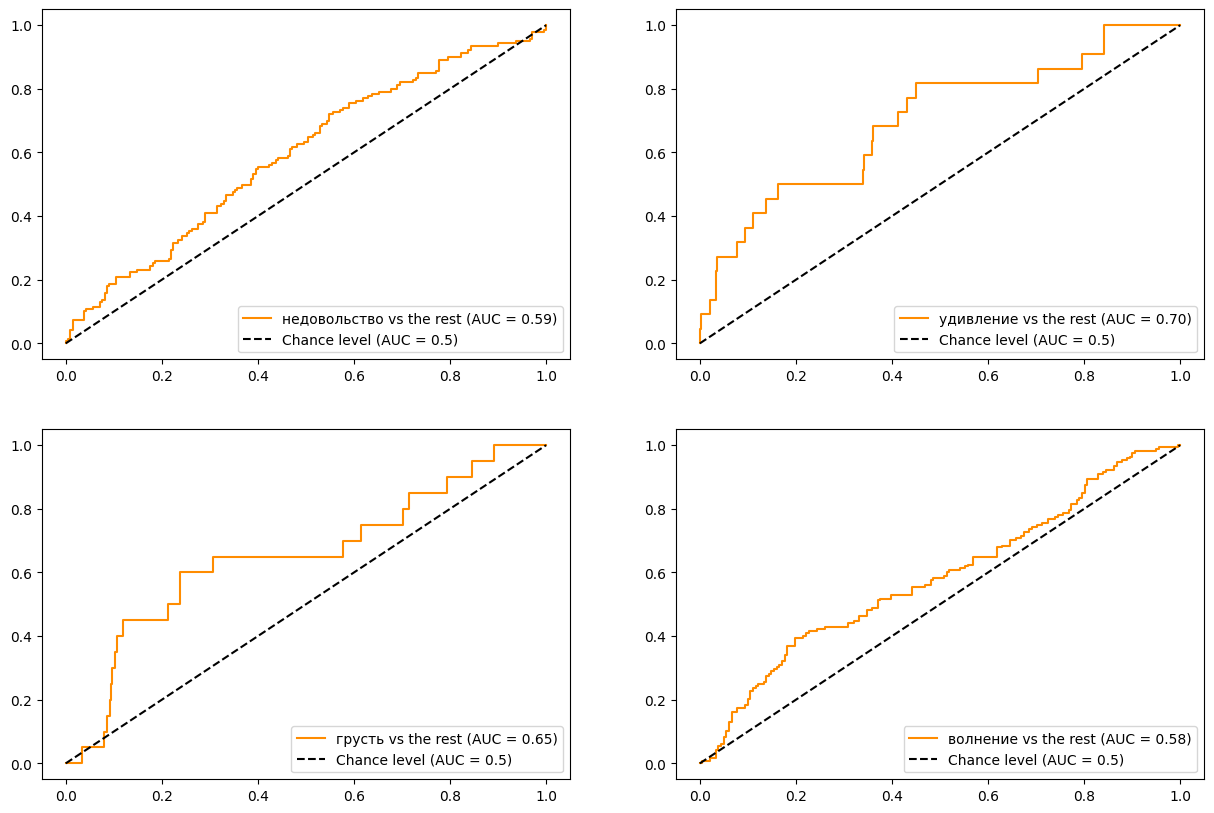

In [143]:
show_roc_curves(y_train, y_test, cbc.predict_proba(X_test), classes=cbc.classes_)

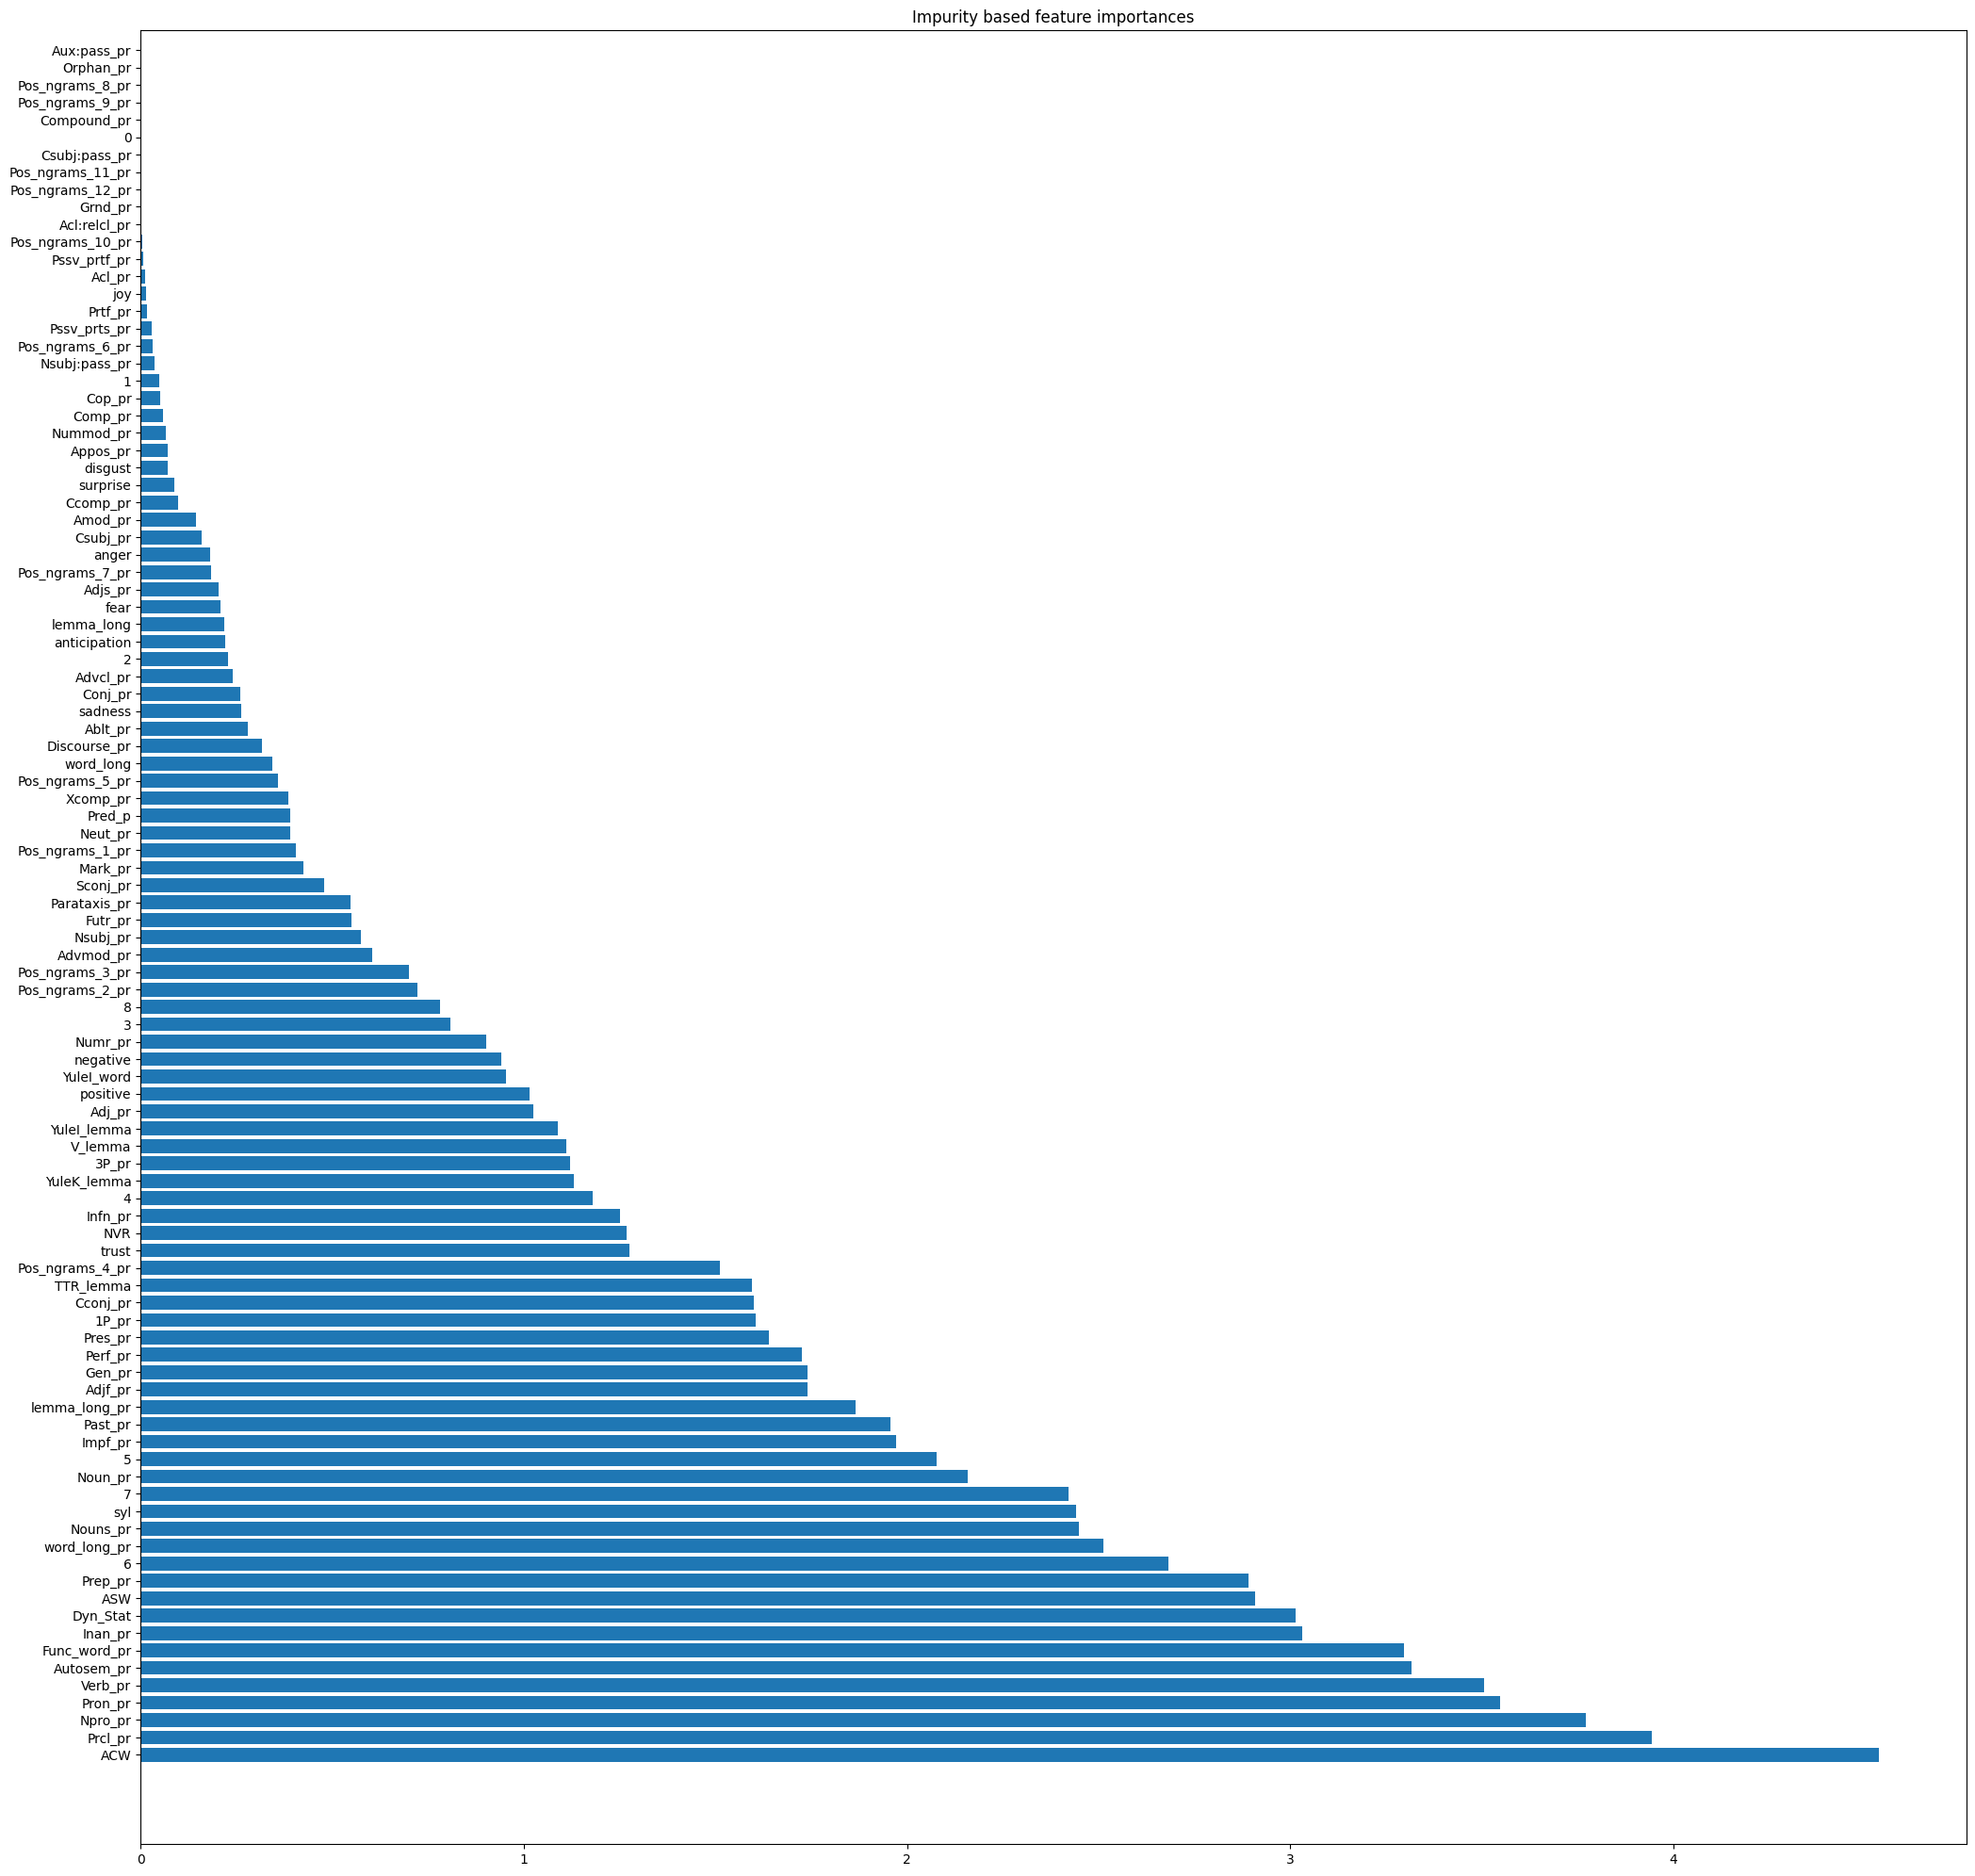

In [140]:
show_feature_importances(cbc.feature_importances_, X_test.columns, "Impurity based feature importances", size=(25,25))

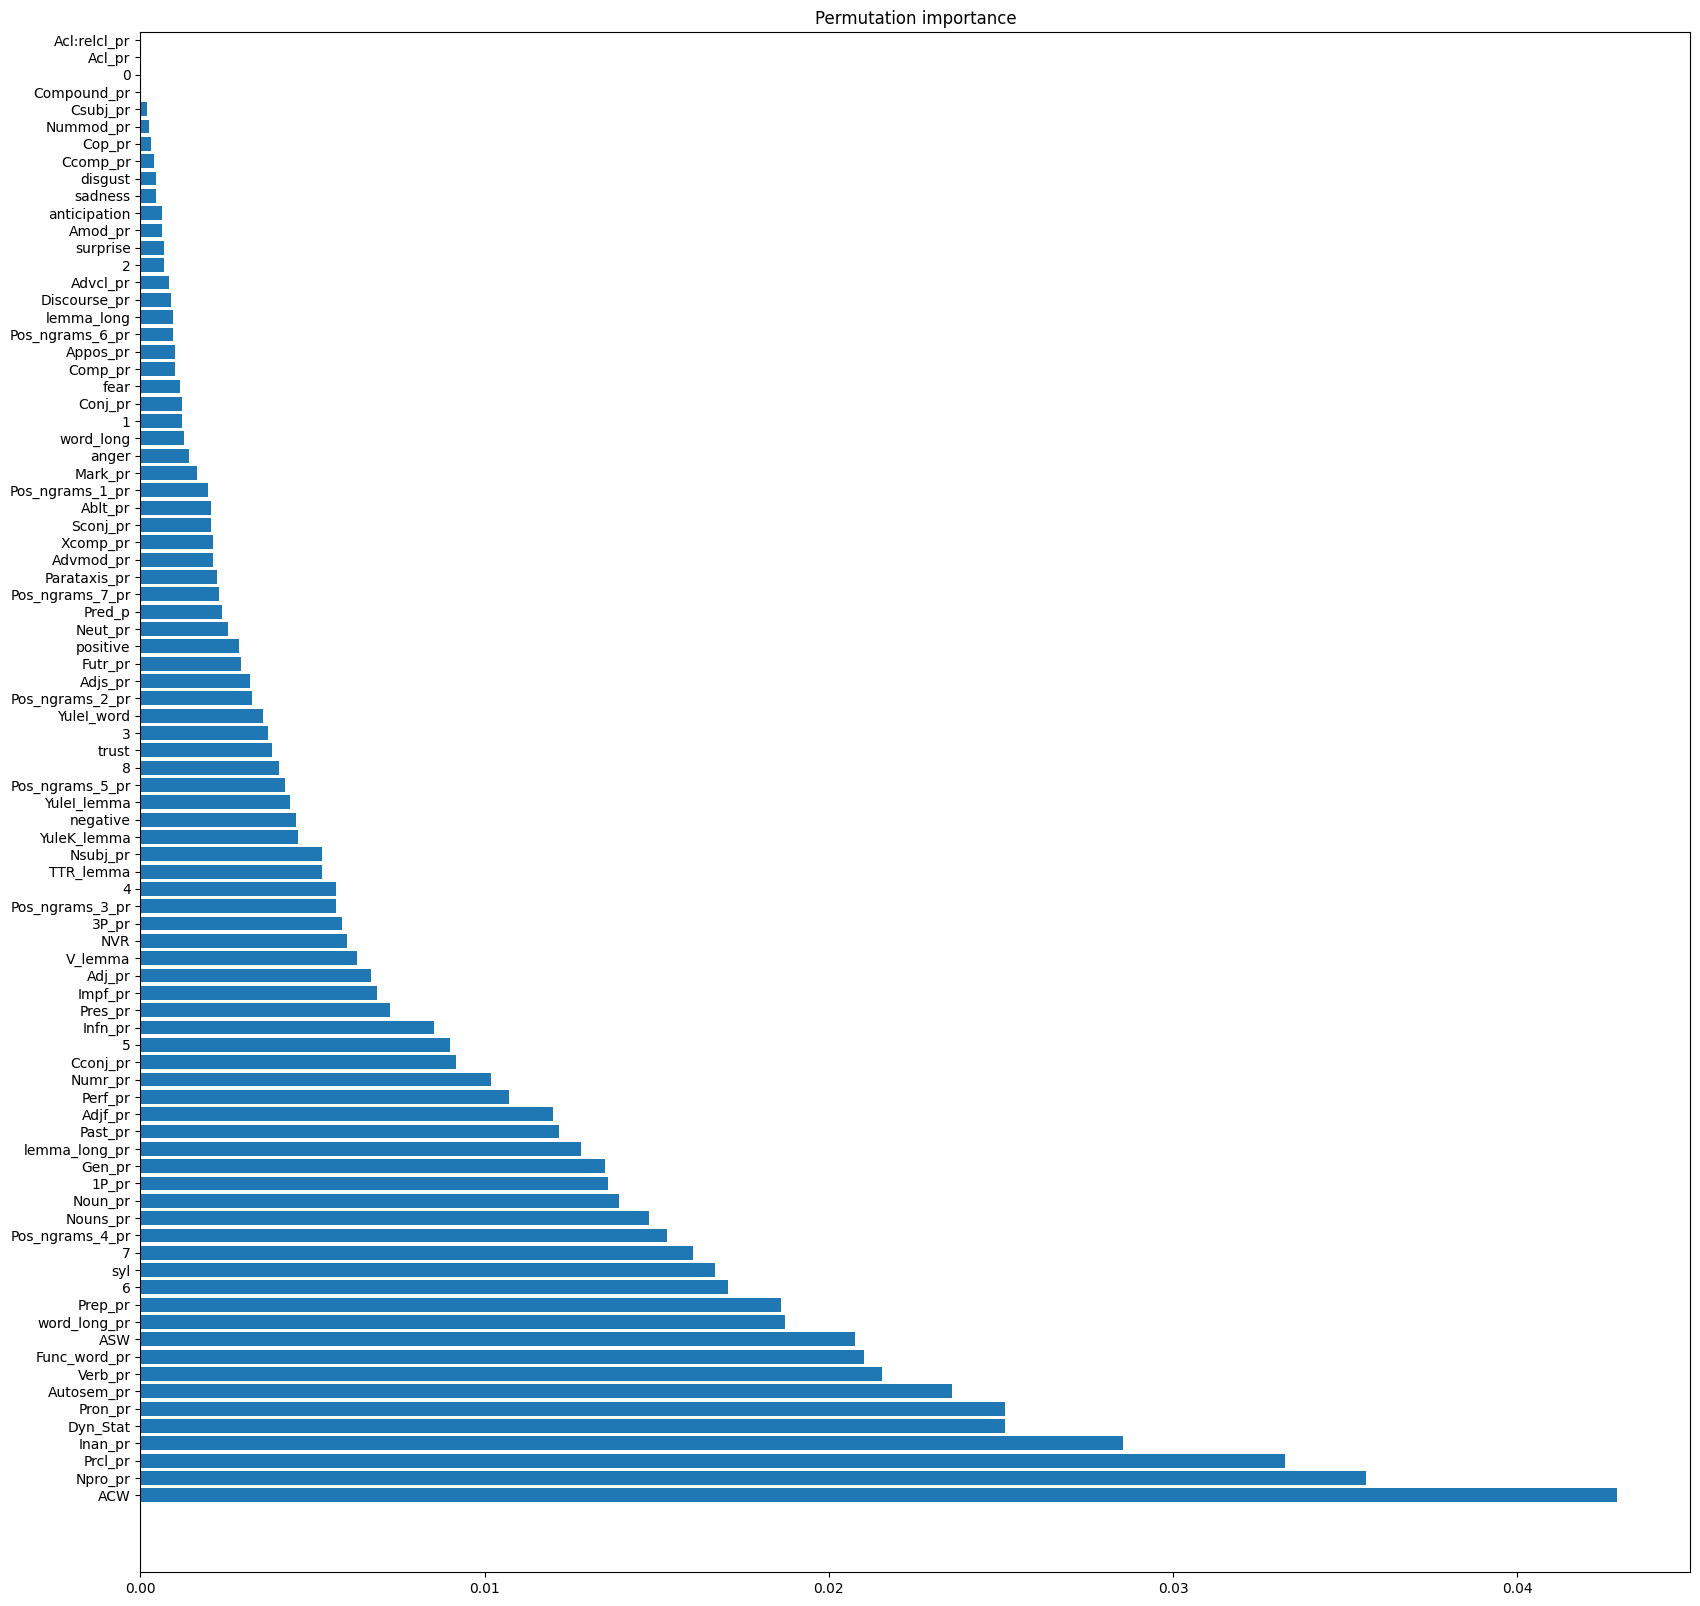

In [141]:
perm_imp_cbc = permutation_importance(cbc, X_train, y_train, n_repeats=5, n_jobs=-1, random_state=42)
show_feature_importances(perm_imp_cbc.importances_mean, X_test.columns, "Permutation importance", size=(20,20))

## Gaussian Naive Bayes

In [116]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)#.predict(X_test)

print_metrics(gnb.predict(X_test), y_test, gnb.predict_proba(X_test))

MSE: 32.254285714285714
Accuracy: 0.04
F-score: 0.019107395231310432
ROC-AUC: 0.6127727213276248


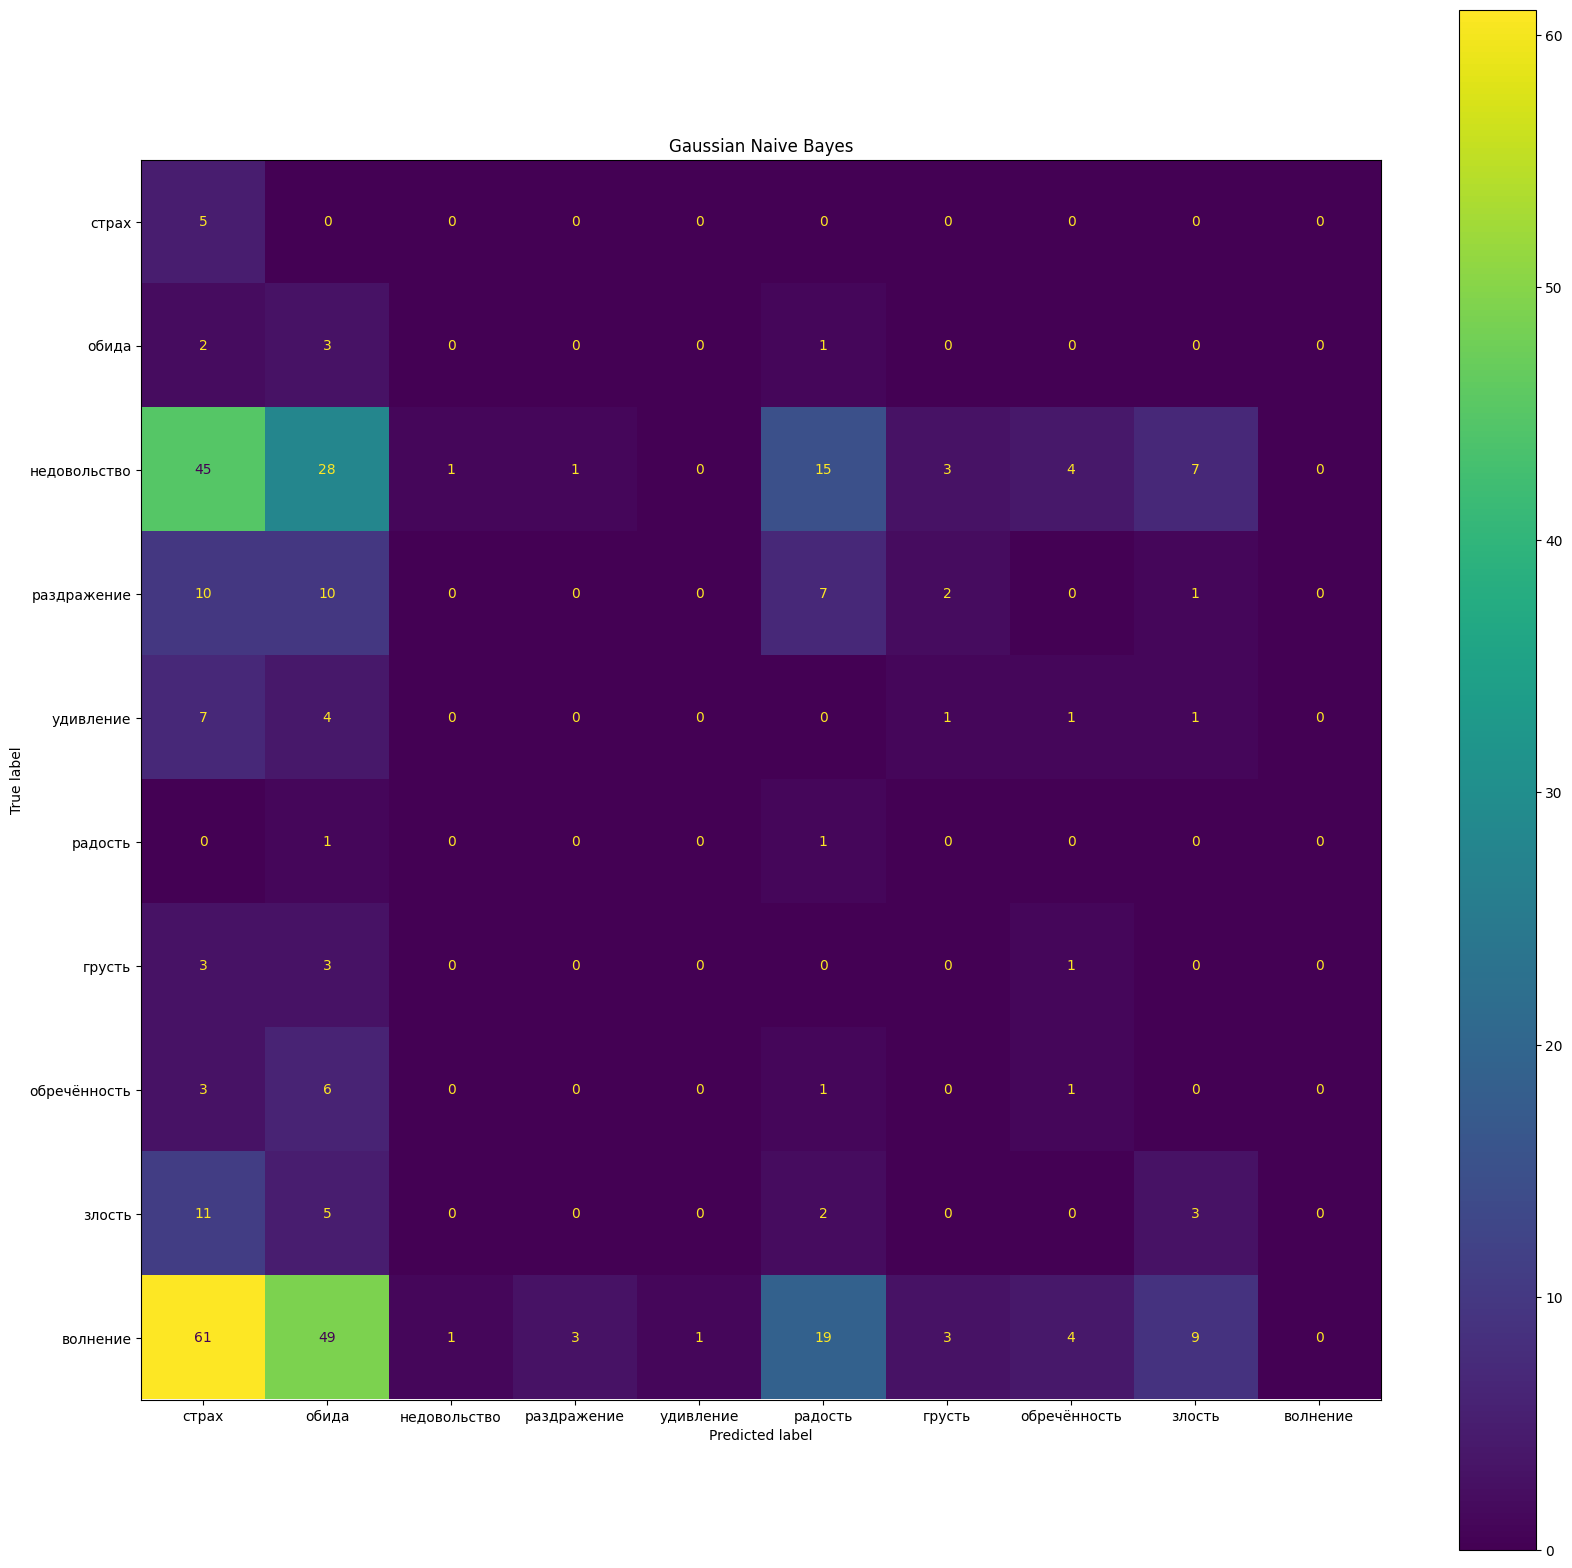

In [117]:
show_conf_matrx(y_test, gnb.predict(X_test), gnb.classes_, "Gaussian Naive Bayes")

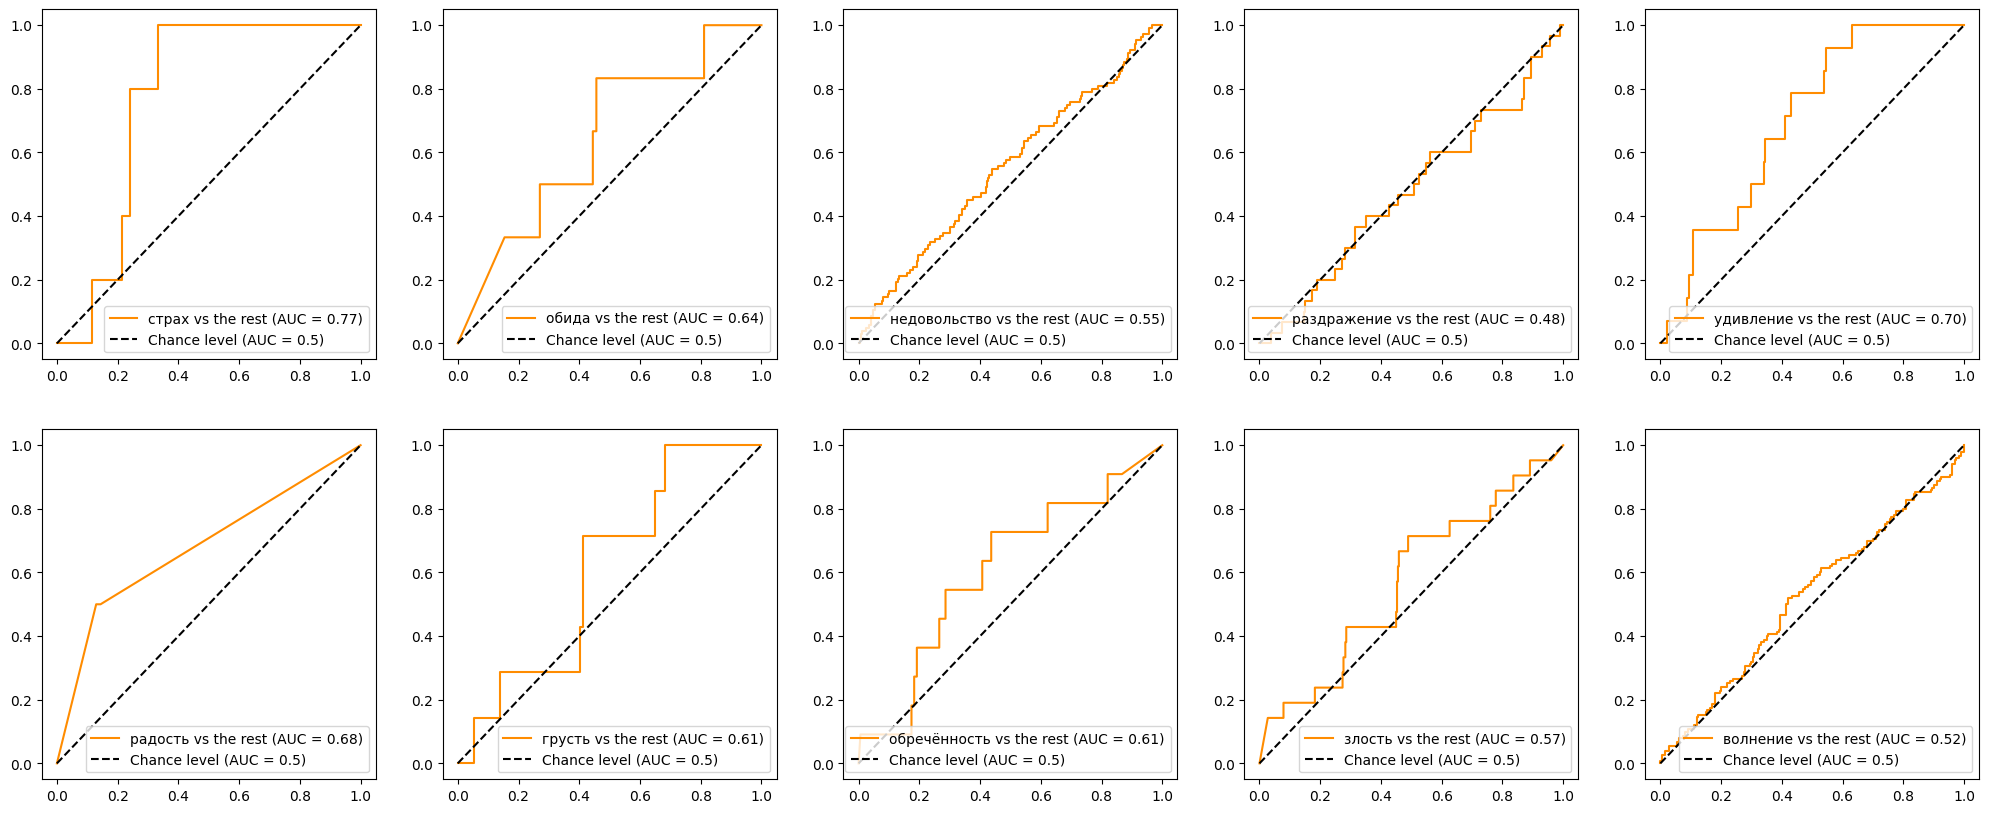

In [118]:
show_roc_curves(y_train, y_test, gnb.predict_proba(X_test), classes=gnb.classes_)

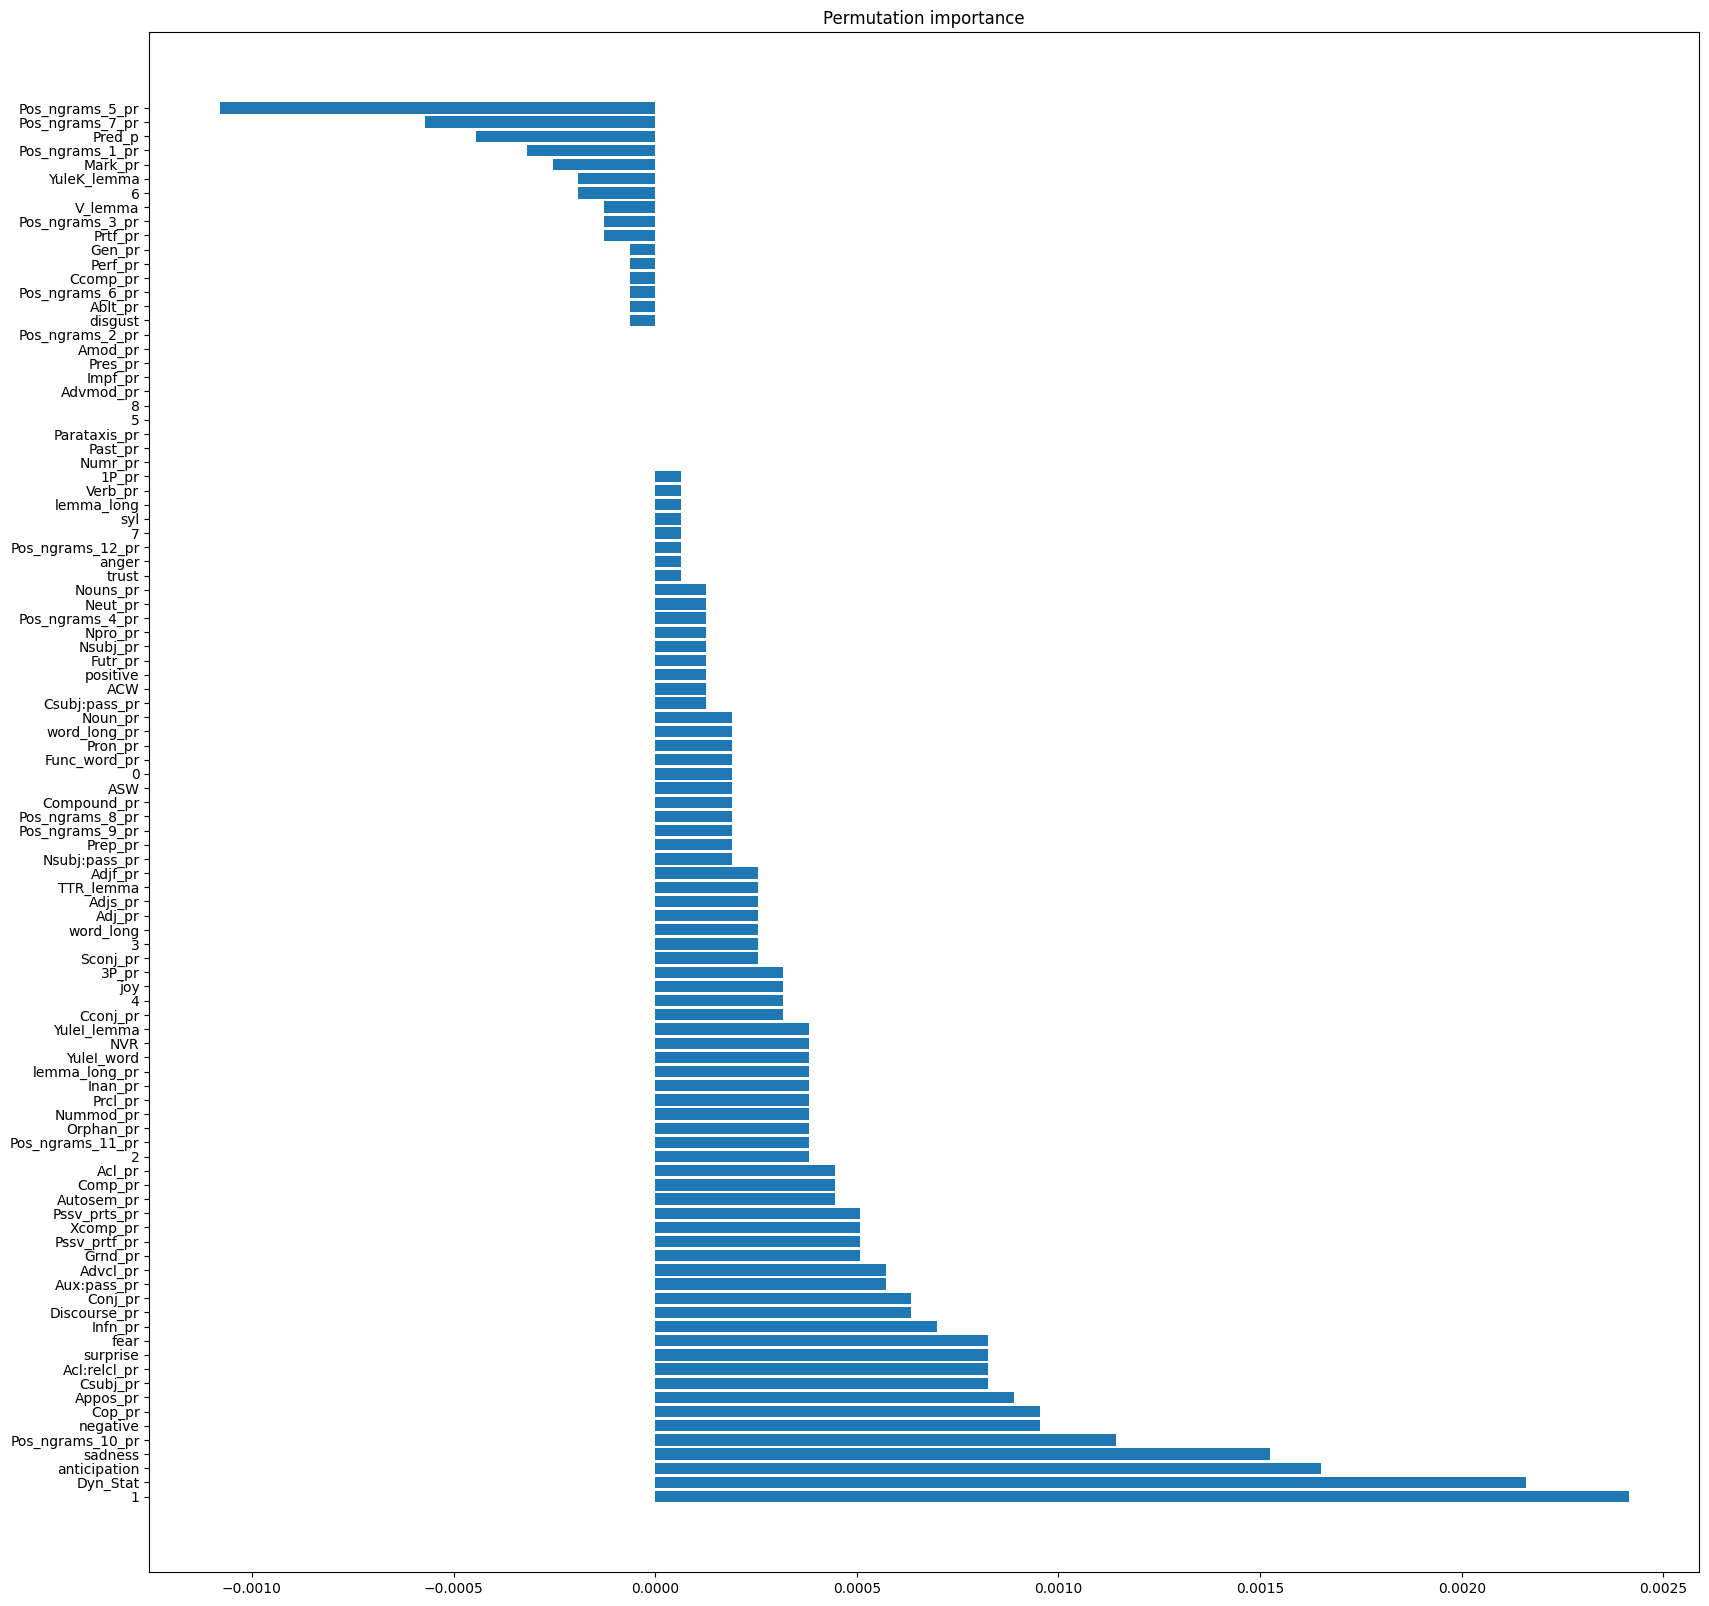

In [119]:
perm_imp_gnb = permutation_importance(gnb, X_train, y_train, n_repeats=5, n_jobs=-1, random_state=42)
show_feature_importances(perm_imp_gnb.importances_mean, X_test.columns, "Permutation importance", size=(20,20))

## K Nearest Neighbors

In [ ]:
knc = KNeighborsClassifier()

knc.fit(X=X_train, y=y_train)

print_metrics(knc.predict(X_test), y_test, knc.predict_proba(X_test))

MSE: 18.825714285714287
Accuracy: 0.39714285714285713
F-score: 0.35004853880444425
ROC-AUC: 0.5575450938372631


## Ridge (Linear classifiers) 

In [ ]:
ridge = RidgeClassifier()

ridge.fit(X=X_train, y=y_train)

print_metrics(ridge.predict(X=X_test), y=y_test)

MSE: 19.837142857142858
Accuracy: 0.44
F-score: 0.35127464618377363


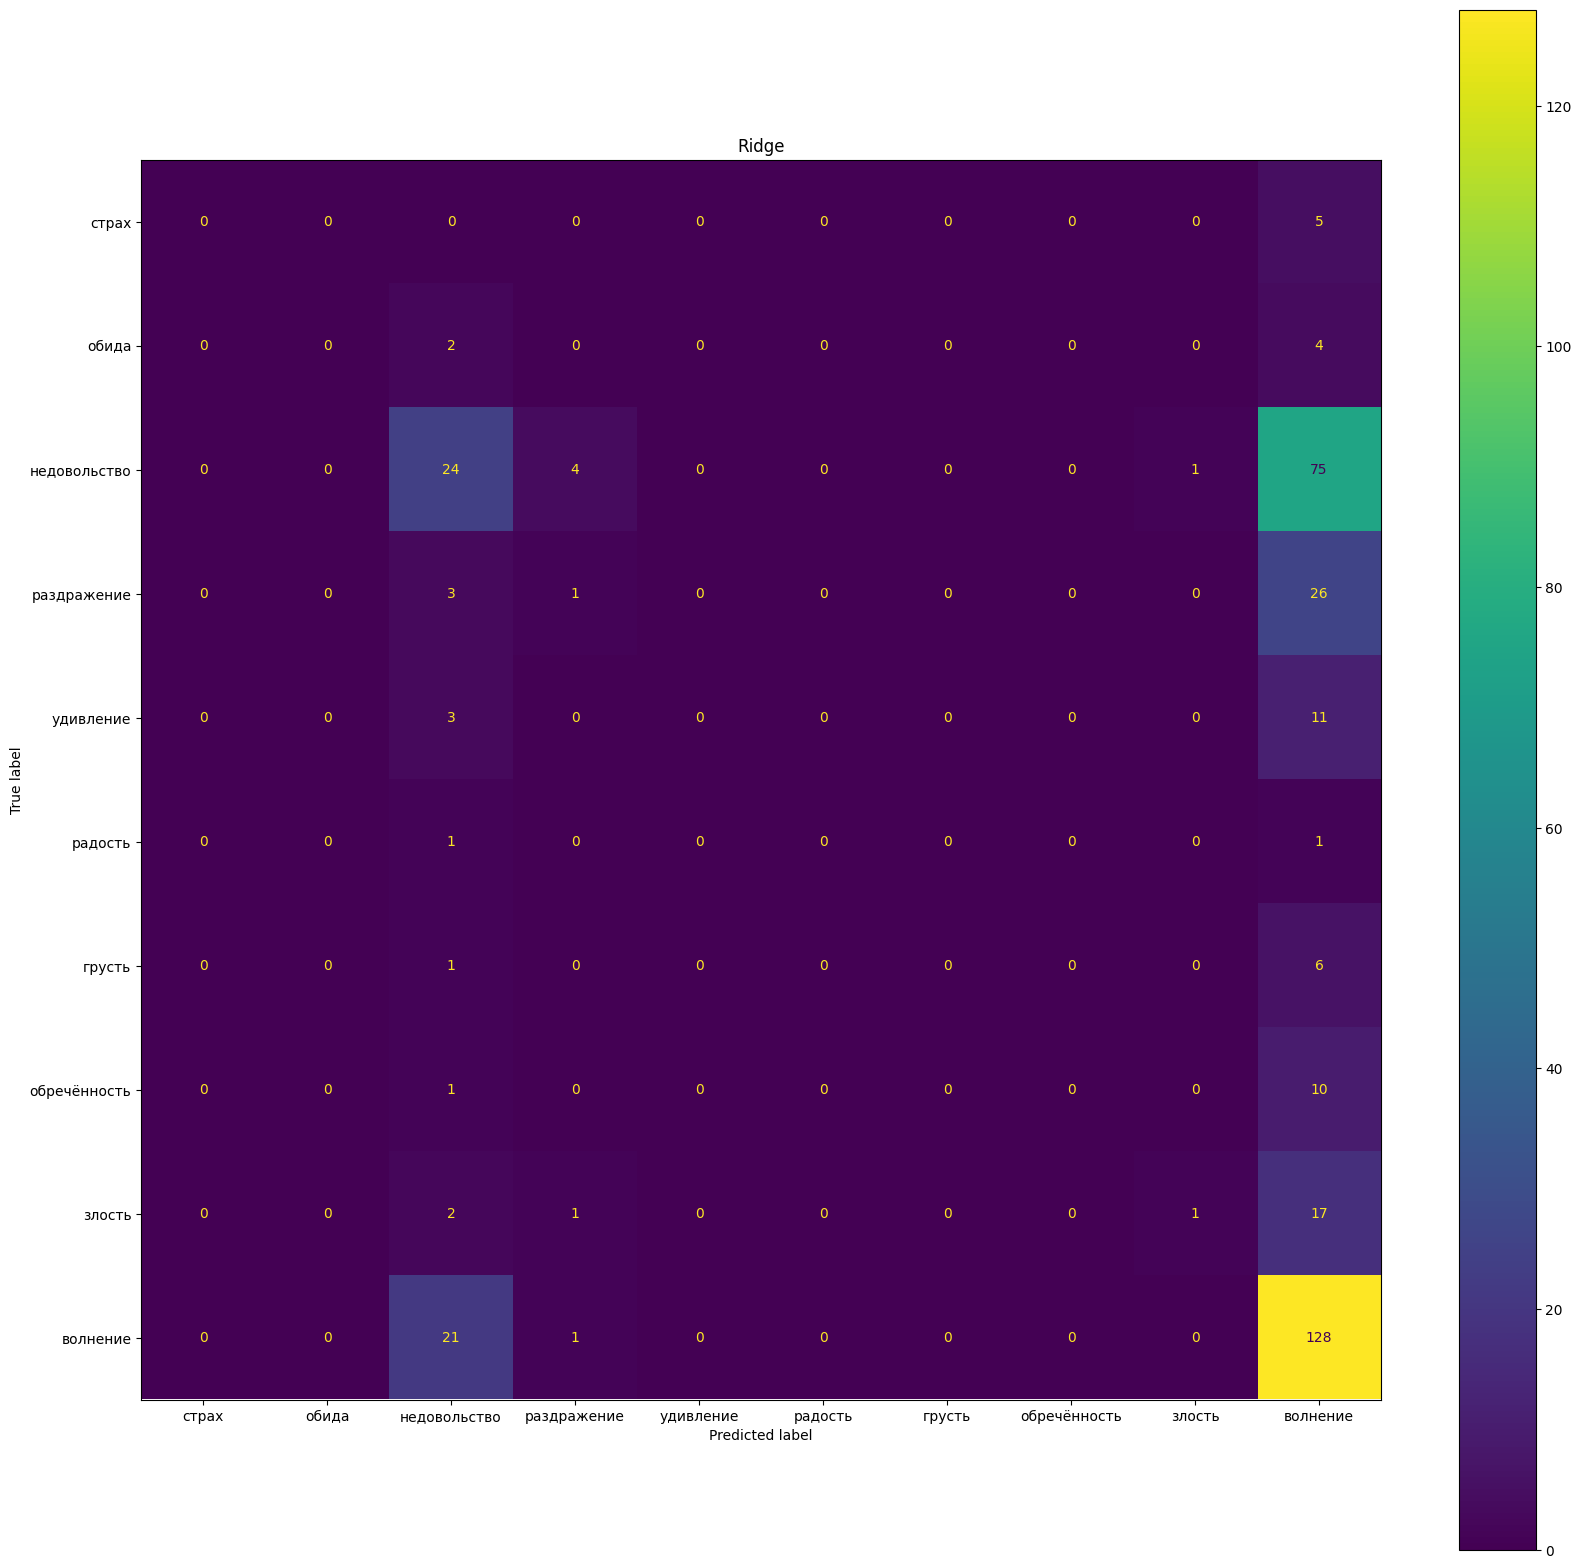

In [ ]:
show_conf_matrx(y_test, ridge.predict(X_test), ridge.classes_, "Ridge")

## Gaussian Process

In [83]:
gpc = GaussianProcessClassifier(kernel=(1.0 * RBF(1.0)),
                                optimizer="fmin_l_bfgs_b",
                                n_restarts_optimizer=0,
                                max_iter_predict=100,
                                warm_start=False,
                                copy_X_train=True,
                                random_state=42,
                                multi_class="one_vs_rest", # "one_vs_one",
                                n_jobs=-1)
gpc.fit(X=X_train, y=y_train)

print_metrics(gpc.predict(X_test), y_test, gpc.predict_proba(X_test))

KeyboardInterrupt: 

## Support Vecs

In [84]:
linSVM = SVC(kernel="linear", C=0.025, random_state=42, probability=True)
rbfSVM = SVC(gamma=2, C=1, random_state=42, probability=True)

In [85]:
rbfSVM.fit(X=X_train, y=y_train)

print("Test:")
print_metrics(rbfSVM.predict(X_test), y_test, rbfSVM.predict_proba(X_test))
print("\nTrain:")
print_metrics(rbfSVM.predict(X_train), y_train, rbfSVM.predict_proba(X_train))

Test:
MSE: 21.255014326647565
Accuracy: 0.4899713467048711
F-score: 0.3314536319849861
ROC-AUC: 0.5043850045378738

Train:
MSE: 0.0
Accuracy: 1.0
F-score: 1.0
ROC-AUC: 0.4377007064868337


In [86]:
linSVM.fit(X=X_train, y=y_train)

print("Test:")
print_metrics(linSVM.predict(X_test), y_test, linSVM.predict_proba(X_test))
print("\nTrain:")
print_metrics(linSVM.predict(X_train), y_train, linSVM.predict_proba(X_train))

Test:
MSE: 20.383954154727792
Accuracy: 0.498567335243553
F-score: 0.44509221439450575
ROC-AUC: 0.5682867940446128

Train:
MSE: 16.948072634597004
Accuracy: 0.564510990761389
F-score: 0.5131997315129823
ROC-AUC: 0.6715009427577447


In [87]:
svm = SVC(random_state = 42, 
          C=2,
          probability=True)
svm.fit(X=X_train, y=y_train)

print("Test:")
print_metrics(svm.predict(X_test), y_test, svm.predict_proba(X_test))
print("\nTrain:")
print_metrics(svm.predict(X_train), y_train, svm.predict_proba(X_train))

Test:
MSE: 19.51862464183381
Accuracy: 0.5157593123209169
F-score: 0.4786626363130661
ROC-AUC: 0.5885119160528224

Train:
MSE: 6.479133482000637
Accuracy: 0.7989805670595731
F-score: 0.7754474046414158
ROC-AUC: 0.953533881483088


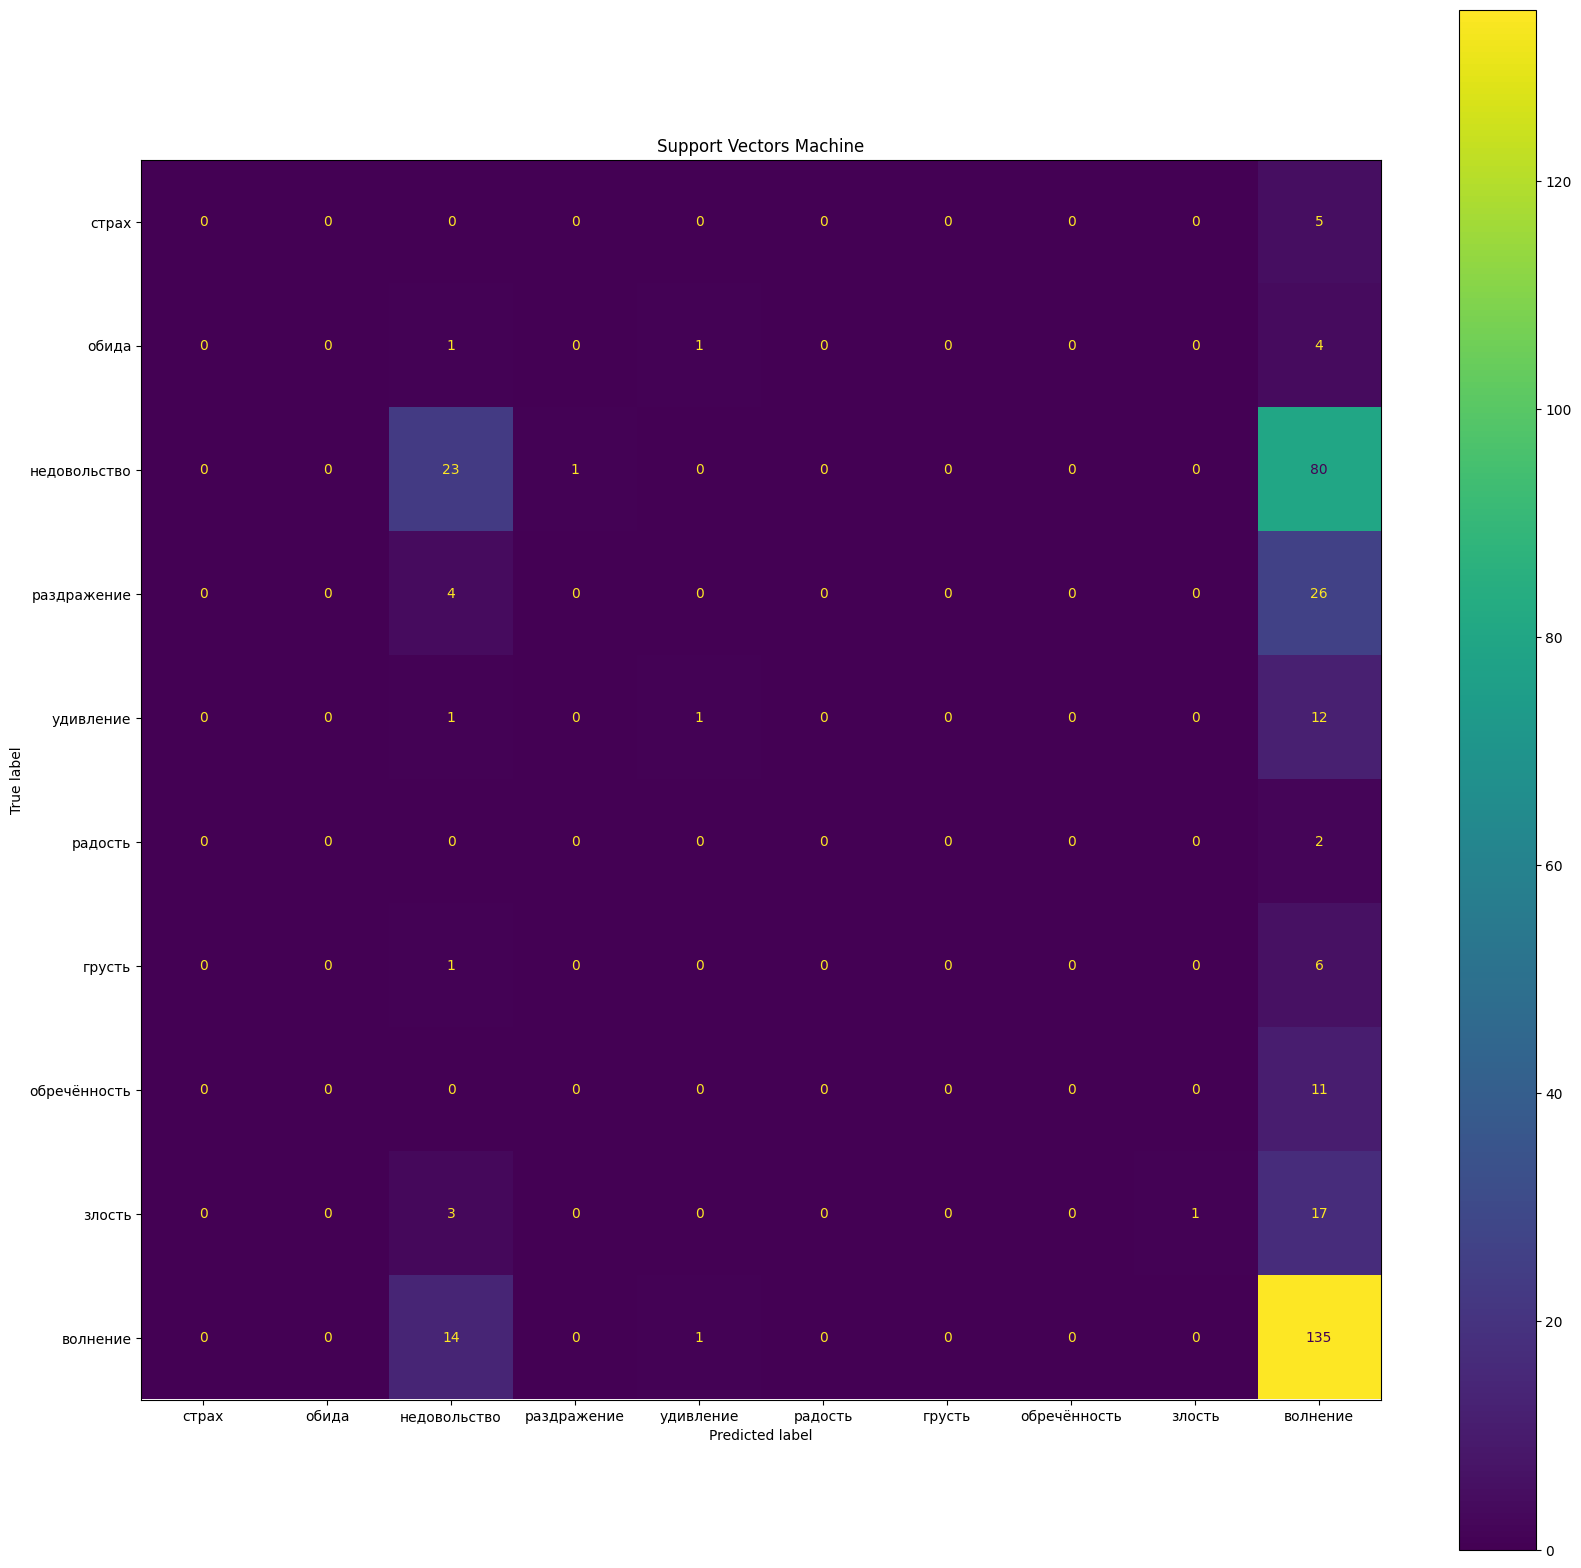

In [149]:
show_conf_matrx(y_test, svm.predict(X_test), svm.classes_, "Support Vectors Machine")

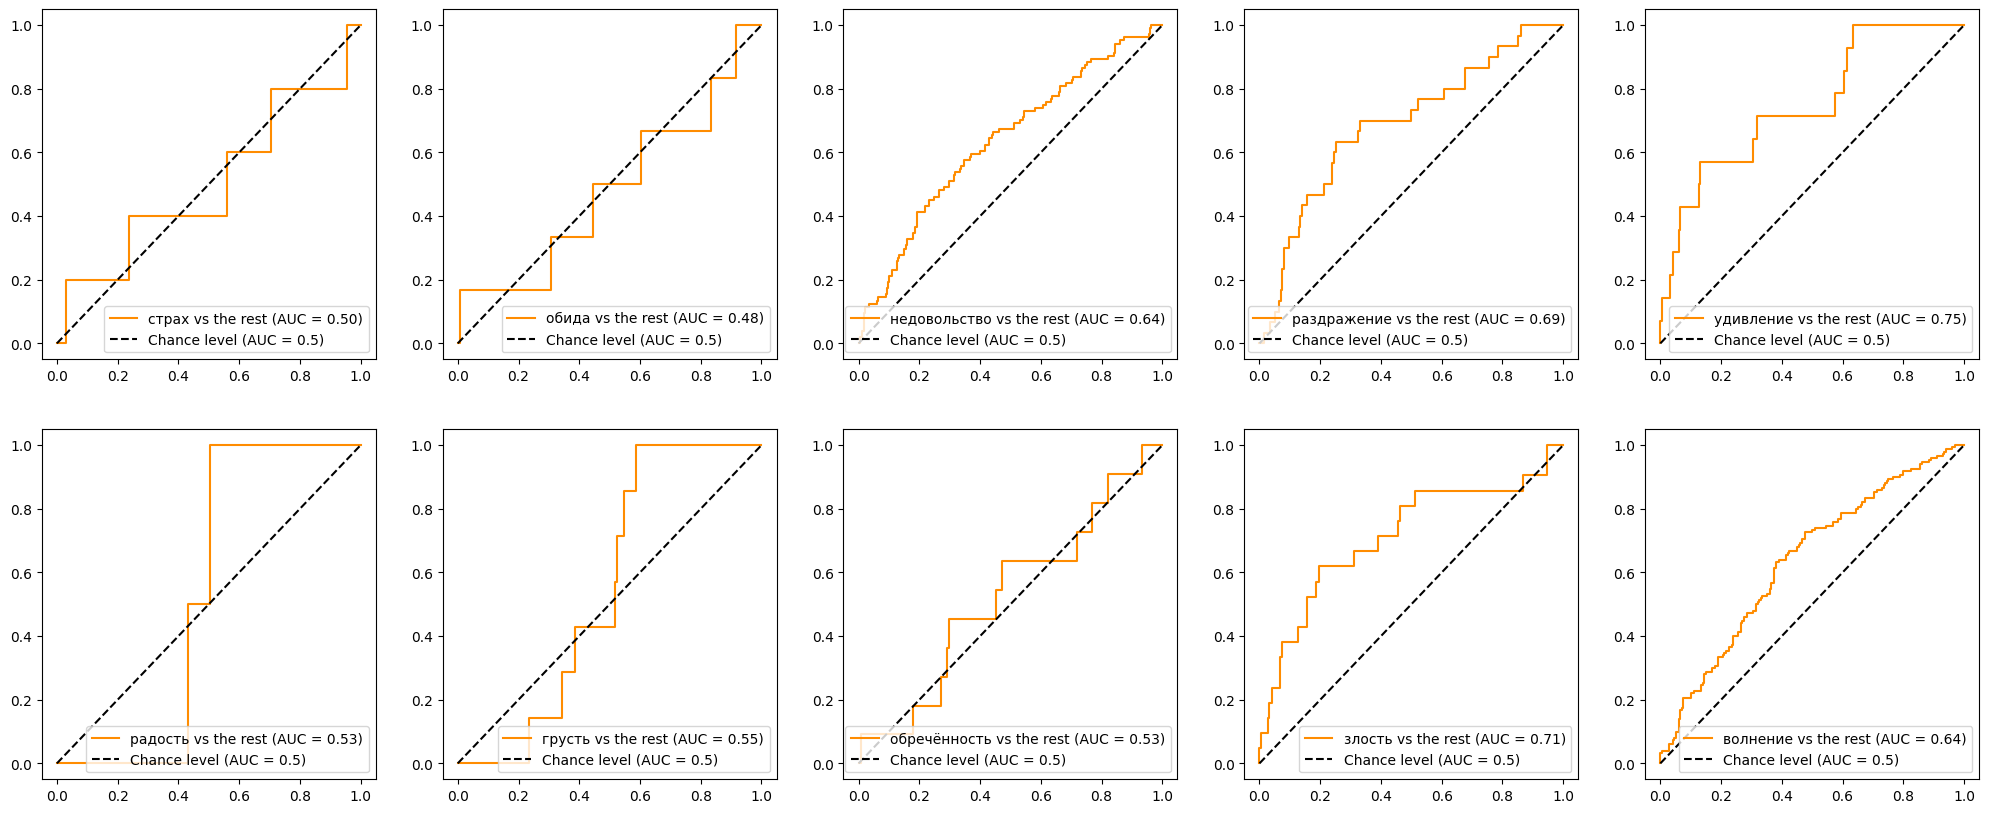

In [150]:
show_roc_curves(y_train, y_test, svm.predict_proba(X_test), svm.classes_)

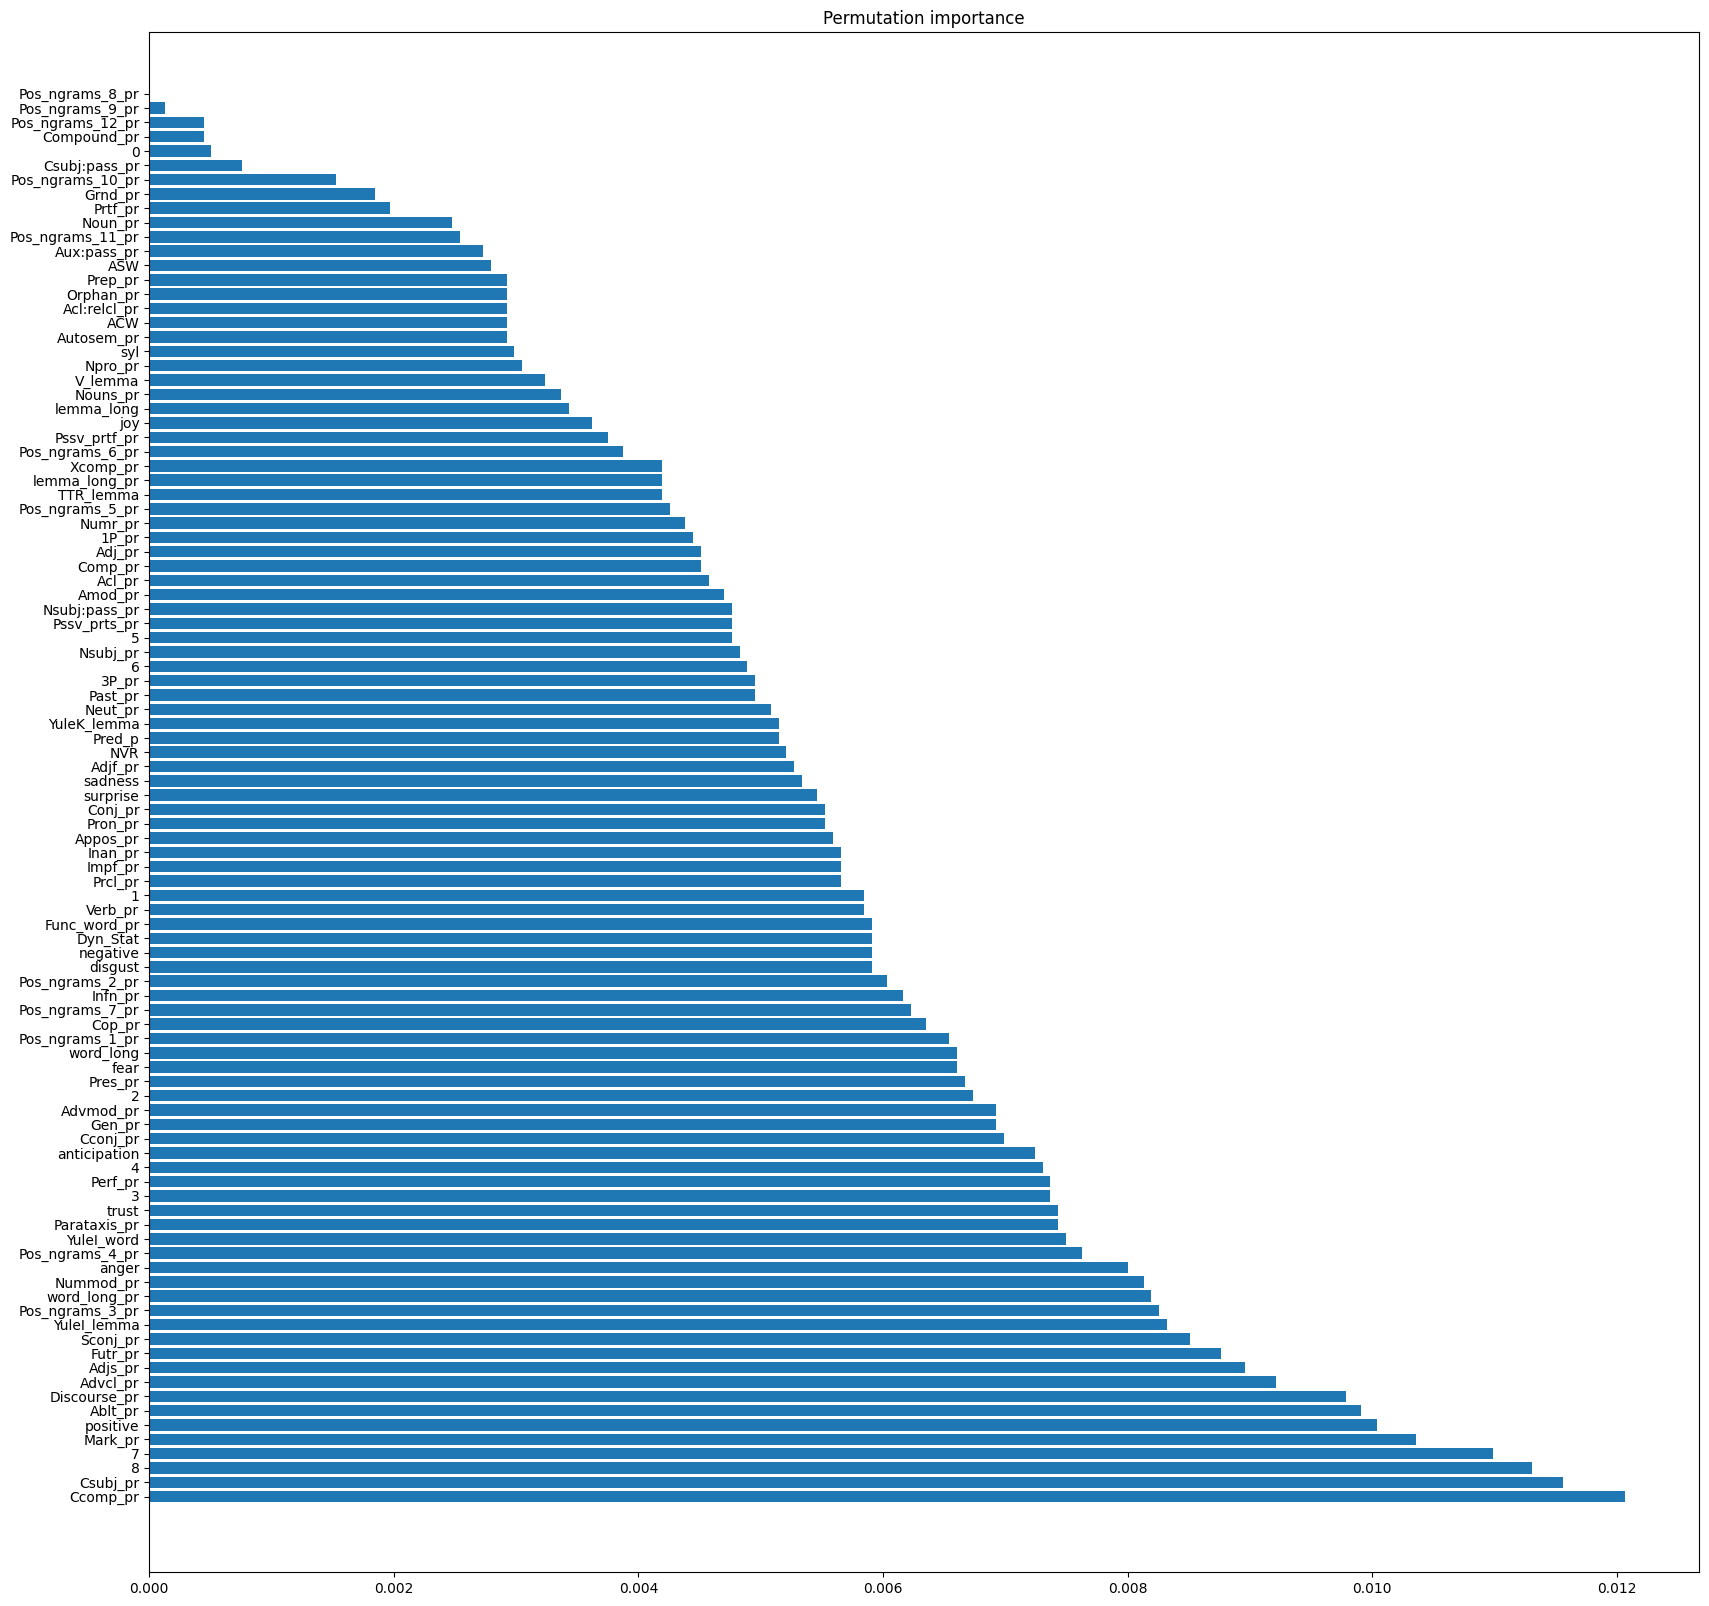

In [151]:
perm_imp_svm = permutation_importance(svm, X_train, y_train, n_repeats=5, n_jobs=-1, random_state=42)
show_feature_importances(perm_imp_svm.importances_mean, X_test.columns, "Permutation importance", size=(20,20))

## AdaBoost

In [88]:
ada = AdaBoostClassifier()
ada.fit(X=X_train, y=y_train)

print("Test:")
print_metrics(ada.predict(X_test), y_test, ada.predict_proba(X_test))
print("\nTrain:")
print_metrics(ada.predict(X_train), y_train, ada.predict_proba(X_train))

Test:
MSE: 21.951289398280803
Accuracy: 0.45272206303724927
F-score: 0.4118695187413059
ROC-AUC: 0.5864570870874144

Train:
MSE: 17.956674100031858
Accuracy: 0.5339280025485823
F-score: 0.4934917182395717
ROC-AUC: 0.6675076918589231
